# Yield Estimation for Orchards - Vision Transformer Vs Well Established Approaches

## Introduction
As the worlds population grows and socio-cultural and lifestyle-driven factors raise awareness for a healthy and sustainable diet, the demand for fresh fruit and vegetables is growing. These circumstances put a lot of pressure on the current fruit market to produce fruit quantities that satisfy the growing demand, while at the same time ensuring a low, competitive pricing and ensuring sustainable farming practices (OECD-FAO Agricultural Outlook, 2021). Achieving these goals in a labour-intensive environment such as fruit orchards presents farmers with a lot of challenges (Zhang et al., 2022). In order to reduce cost, farmers have to reduce the manual labour involved in the management of orchards, as well as keeping production at high yields with high quality. In order to achieve this, fruit production has shifted towards the concepts of precision farming and the so-called "Intelligent Orchard". Precision farming describes the management of spatial and temporal variability of fields using Information, Computers and Technology (ICT). Spatial and temporal variability is analysed by investigating crop and soil properties. Based on this data, a field is divided into different management zones, which are used to apply appropriate inputs to achieve the best management / yield and increase profitability while reducing environmental impact (Gemtos et al., 2013). One key application in order to generate management zones is a technique called yield mapping. During yield mapping, fruits have been gathered in bins, which were weighted and tagged with additional GPS data. This data was then used to generate yield maps, which combined with soil data and historical data can be used to generate yield maps (Gemtos et al., 2013). However, this still involved a lot of manual labour, therefore, the concept of an intelligent orchard has been developed, which remains a very active research field today. In an intelligent orchard, many manual labor tasks are replaced by automatic systems, that monitor, manage and even harvest fruits by utilizing robots and unmanned aerial vehicle technology (Lyu et al., 2022), (Zhang et al., 2022). Especially, detecting, counting, tracking and classification of fruits in real time are essential to efficiently and reliably deploy these techniques. Recently, the application of computer vision technology has become a research hotspot to solve these different needs, such as automatic disease detection, fruit detection and classification (Lyu et al., 2022). Current research successfully deployed state-of-the-art computer vision models such as Yolo derivates and Convolutional neural networks in fruit orchards. Zheng et al. proposed YOLO BP, a modified Yolo V4 that includes a trimmed backbone to extract high-quality features and improve real-time performance in green citrus orchards (Zheng et al., 2021). Bargoti & Underwood adapted multiple Faster R-CNN architectures to achieve state-of-the-art performance through data augmentation and transfer learning techniques in apple, mango and almond fruit detection (Bargoti & Underwood, 2017). Koirala et al. compared two stage object detection techniques with single stage detectors for mango detection and based on their findings proposed a MangoYOLO model (Koirala et al., 2019). Mirhaji et al. adapted YoloV4 for orange detection to provide data for precision farming applications (Mirhaji et al., 2021). All the models mentioned above achieve state-of-the-art performance with high F1-scores at around 0.95 and most of them can also be applied in real time on small edge AI computing plattforms such as the Nvidia Jetson NX. However, newer models such as Vision Transformers (VIT) have not yet gained traction in the domain of fruit detection, even though it has been shown that they can outperform traditional CNN based approaches in various computer vision tasks such as fruit quality evaluation, digital holography and image classification in terms of performance and robustness (Kumar & R, 2022)(Cuenat & Couturier, 2022)(Uparkar et al., 2023). Therefore, in this paper, current state-of-the-art vision transformers for object detection are adapted for fruit detection in orchards on the acfr-fruit-dataset (Bargoti & Underwood, 2017) and compared to various Faster-R-CNN and Yolo baselines.

## Approach
First the characteristics of the acfr-fruit-dataset are analysed and the dataset is converted into an object detection standard COCO format. Afterwards, two Vision Transformers for object detection (Yolos and Detr) are fine-tuned on the train split of the dataset and are evaluated using the widely used COCO evaluator. The returned precision for the Intersection-over-Union in the $[0.5,1]$-Intervall for a maximum of 100 Detections and the Recall for the Intersection-over-Union in the $[0.5, 0.95]$-Intervall are used to compute the F1-score. The F1-Score is the harmonic mean of precision and recall and therefore combines both metrics in a relatively durable metric against class imbalance but more importantly a comparable metric that involves both precision and recall (Korstanje, 2021). Both models are then compared against three different variations of Convolutional Neural Networks (CNN), that have been tested and trained by the authors of the dataset, ZFNet, VGG16 and a Pixel-wise CNN. In addition to raw performance, the real-time capabilities of both transformers are also evaluated by taking the average inference time over a batch of 250 samples from the COCO evaluator and comparing it against other state-of-the-art models such as the Yolo derivates mentioned earlier in terms of the processing time per image in milliseconds, the achievable frames per second (fps) and their number parameters.

## The Dataset
The acfr-fruit-dataset has been created specifically to help researchers test and design reliable deep learning models for fruit detection in orchards by offering image data of three significantly orchard types across three different datasets (Bargoti & Underwood, 2017):
- Apples
- Mangoes
- Almonds

Each with their own dataset. The data has been captured by a general purpose research ground vehicle, which has been equipped with various image sensors, an external flashlight and a hand-held DSLR camera. The vehicle traversed through the orchard rows collecting full tree image data. The apple trees have been trellised in advance, to enable the ground vehicle to be in close proximity to the fruit and thus reducing the need for a high resolution sensor. For Mango and almond image collection, this was not possible, thus in order to capture mango fruits a higher resolution sensor with external strobe lighting was used with a small exposure time. For the almond trees, this approach was also infeasible, as almond trees have larger canopies and can host up to 10000 almonds per tree, which are smaller than apples and mangoes. To account for that, a hand-held DSLR camera was used to capture the images of the almond trees (Bargoti & Underwood, 2017). Imagery originally span entire trees to efficiently model the primary objective of yield mapping and estimation, however because of hardware constraints using the full resolution images is infeasible, to overcome these constraints, smaller sub-images were randomly sampled from the pool of larger images that have been acquired to build a representative training and testing objective (Bargoti & Underwood, 2017). The whole dataset has been manually annotated with rectangular bounding boxes (bbox) for almonds and mangoes and circular bboxes for apples, as it was deemed that they were more suitable for the characteristics of apples (Bargoti & Underwood, 2017).

The dataset comes in a .csv format:
``#item,x,y,dx,dy,label``
where each row contains an item identifier, the x and y coordinate along with the width and height of the bounding box and the corresponding label. For apples the same format is used, but x and y are the center coordinates and width and height are exchanged against the radius of the circle. Annotations are stored in a seperate folder from the images. First the dataset is read into memory by building a global dataset representation in form of a dictionary, that holds all three datasets, along with its data split references in one accessible variable.

In [1]:
import os.path

import pandas as pd
from os import listdir
from tqdm import tqdm
def build_annotation_dataframe(path: str) -> pd.DataFrame: # function to read annotations in CSV format
    annotations = pd.DataFrame()
    for i, annotation in enumerate(tqdm(listdir(path))):
        part = pd.read_csv(os.path.join(path, annotation))
        part["picture_id"] = [annotation[:-4] for i in range(len(part))]
        part["picture_id"] = part["picture_id"].astype("string")
        if i == 0:
            annotations = part
            continue
        annotations = pd.concat([annotations,part])
    annotations.reset_index(inplace=True, drop=True)
    return annotations

In [2]:
# create global dataset representation
dataset = {
    "almonds": {
        "global_df": build_annotation_dataframe(path="datasets/acfr-fruit-dataset/almonds/annotations"),
        "train_ids": pd.read_csv("datasets/acfr-fruit-dataset/almonds/sets/train.txt", names=["picture_id"]).picture_id.astype("string"),
        "test_ids": pd.read_csv("datasets/acfr-fruit-dataset/almonds/sets/test.txt", names=["picture_id"]).picture_id.astype("string"),
        "val_ids": pd.read_csv("datasets/acfr-fruit-dataset/almonds/sets/val.txt", names=["picture_id"]).picture_id.astype("string")
    },
    "apples": {
        "global_df": build_annotation_dataframe(path="datasets/acfr-fruit-dataset/apples/annotations"),
        "train_ids": pd.read_csv("datasets/acfr-fruit-dataset/apples/sets/train.txt", names=["picture_id"]).picture_id.astype("string"),
        "test_ids": pd.read_csv("datasets/acfr-fruit-dataset/apples/sets/test.txt", names=["picture_id"]).picture_id.astype("string"),
        "val_ids": pd.read_csv("datasets/acfr-fruit-dataset/apples/sets/val.txt", names=["picture_id"]).picture_id.astype("string")
    },
    "mangoes": {
        "global_df": build_annotation_dataframe(path="datasets/acfr-fruit-dataset/mangoes/annotations"),
        "train_ids": pd.read_csv("datasets/acfr-fruit-dataset/mangoes/sets/train.txt", names=["picture_id"]).picture_id.astype("string"),
        "test_ids": pd.read_csv("datasets/acfr-fruit-dataset/mangoes/sets/test.txt", names=["picture_id"]).picture_id.astype("string"),
        "val_ids": pd.read_csv("datasets/acfr-fruit-dataset/mangoes/sets/val.txt", names=["picture_id"]).picture_id.astype("string")
    }
}

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1964/1964 [00:05<00:00, 352.79it/s]


After reading it into memory, the dataset can be analyzed using pandas and numpy respectively. The almond dataset, consists of a total of 620 images, with the apple set including 1120 and for mangoes there are 1964 images. However not all of them depict fruits. For almonds there are only 48 images without fruits, marking only a small portion of images without annotations. For apples and mangoes on the other hand 50% or more of the images in the dataset are annotationless / fruitless. This goes inline with Bargoti & Underwood explanation about fruit sparsity variations in different fruit types. Thus, this result is expected and approximates the true distribution of fruits in the tree canopies.

In [3]:
print(f" Pictures without Annotations for Almonds: {len(listdir('datasets/acfr-fruit-dataset/almonds/annotations/')) - len(dataset['almonds']['global_df'].picture_id.unique())}, total number of pictures: {len(listdir('datasets/acfr-fruit-dataset/almonds/annotations/'))}")
print(f" Pictures without Annotations for Apples: {len(listdir('datasets/acfr-fruit-dataset/apples/annotations/')) - len(dataset['almonds']['global_df'].picture_id.unique())}, total number of pictures: {len(listdir('datasets/acfr-fruit-dataset/apples/annotations/'))}")
print(f" Pictures without Annotations for Mangoes: {len(listdir('datasets/acfr-fruit-dataset/mangoes/annotations/')) - len(dataset['almonds']['global_df'].picture_id.unique())}, total number of pictures: {len(listdir('datasets/acfr-fruit-dataset/mangoes/annotations/'))}")

 Pictures without Annotations for Almonds: 48, total number of pictures: 620
 Pictures without Annotations for Apples: 548, total number of pictures: 1120
 Pictures without Annotations for Mangoes: 1392, total number of pictures: 1964


In the following Figure, the distribution of Samples, Fruit counts and the average fruit count per image is depicted. On the left, the distribution of samples, visualises the above findings again, with respect to its relative counts. Here it gets even more clear, that the global dataset is imbalanced in terms of fruit samples with mangoes marking over 50% of the global amount samples. The inner ring of the pie chart displays the relative amount of unlabeled and labeled data, with the unlabeled data marked in light green, purple and pink respectively. Here it can be observed that for other than mangoes, unlabeled data only marks a small overall percentage of the fruit specific dataset. An explanation as to why the amount of imagery varies so drastically between fruit types has unfortunately not been given by the authors. However, taking the distribution of fruit counts (depicted in the middle), as well as the average fruit count per image (depicted on the right) into account, it can be hypothesized, that the authors wanted to achieve an equal representation of fruit samples across the three datasets. As the distribution of fruit counts is fairly even only varying by about 6.5%. This hypothesis is further underlined by observing the average fruit counts per image, as almonds have on average 8 fruits per image, whereas apples and mangoes have only around 4-5 fruits per image, with mangoes having the lowest fruit density.

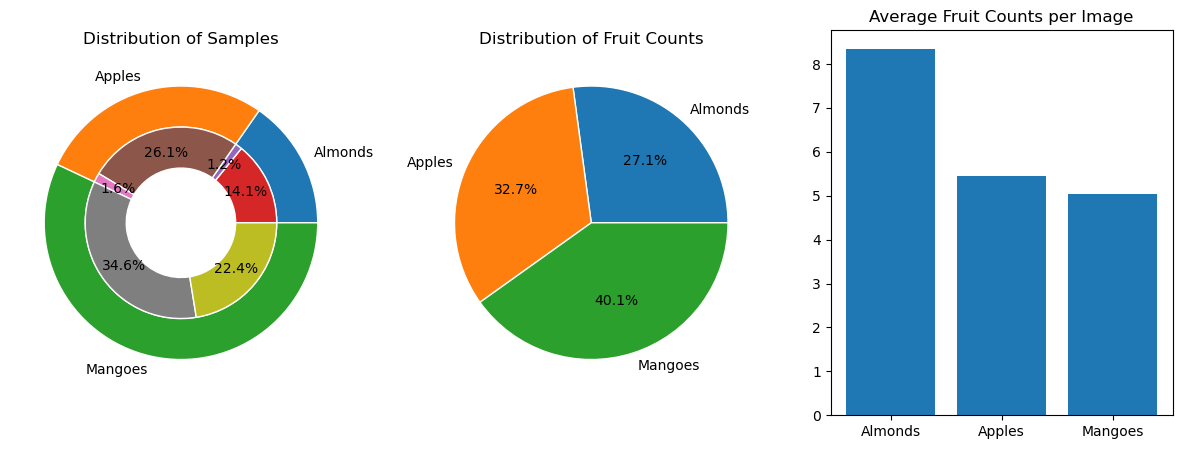

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Plot distribution of samples, fruit counts and average count per image for the 3 different sets
x_pictures = np.array([
    [len(dataset["almonds"]["global_df"].picture_id.unique()), len(listdir('datasets/acfr-fruit-dataset/almonds/annotations/')) - len(dataset["almonds"]["global_df"].picture_id.unique())],
    [len(dataset["apples"]["global_df"].picture_id.unique()), len(listdir('datasets/acfr-fruit-dataset/apples/annotations/')) - len(dataset["apples"]["global_df"].picture_id.unique())],
    [len(dataset["mangoes"]["global_df"].picture_id.unique()), len(listdir('datasets/acfr-fruit-dataset/mangoes/annotations/')) - len(dataset["apples"]["global_df"].picture_id.unique())]
])
x_fruits = [len(dataset["almonds"]["global_df"]), len(dataset["apples"]["global_df"]), len(dataset["mangoes"]["global_df"])]
fruit_per_image = [dataset["almonds"]["global_df"].groupby(by="picture_id")['#item'].count().mean(), dataset["apples"]["global_df"].groupby(by="picture_id")['#item'].count().mean(), dataset["mangoes"]["global_df"].groupby(by="picture_id")['#item'].count().mean()]
labels = ["Almonds", "Apples", "Mangoes"]
size = 0.3
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].pie(x_pictures.sum(axis=1), radius=1, labels=labels, wedgeprops=dict(width=0.3, edgecolor='w'))
ax[0].pie(x_pictures.flatten(), radius=1-size, autopct='%1.1f%%',wedgeprops=dict(width=0.3, edgecolor='w'), pctdistance=0.75) # inner pie chart to display the ratio of images without fruits
ax[0].set_title("Distribution of Samples")
ax[1].pie(x_fruits, labels=labels, autopct='%1.1f%%', wedgeprops=(dict(edgecolor='w')))
ax[1].set_title("Distribution of Fruit Counts")
ax[2].bar(x=labels, height=fruit_per_image)
ax[2].set_title("Average Fruit Counts per Image")
plt.show()

The dataset comes with predefined train, test and validation splits out of the box. The Sample distribution is depicted in the Figure below. As expected, the train set marks the biggest portion of the whole set with 67.7%, followed by the train and validation set respectively, which both use 16.1% of the data. In order to create these splits, Bargoti & Underwood sampled the data, such that each split contained data from different parts of the orchard, to account for different management zones which have different characteristics in order to minimise biased results. Images that do not contain fruits in the train set have been discarded. Because of these characteristics of the splits, they are used unchanged throughout this paper.

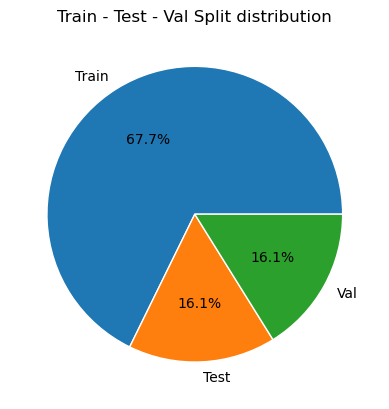

In [53]:
# Display distribution of train test and validation set
x = [len(dataset["almonds"]["train_ids"]), len(dataset["almonds"]["test_ids"]), len(dataset["almonds"]["val_ids"])]
plt.pie(x, labels=["Train", "Test", "Val"], autopct="%1.1f%%", wedgeprops=dict(edgecolor="w"))
plt.title("Train - Test - Val Split distribution")
plt.show()

Below random samples from the three different datasets are visualized, along with their annotations. This has been done to personally get familiar with the data. It can be observed, that the lighting conditions, image shape and overall image features are vastly different. The samples from the almond dataset have an orange background with cyan leaves and a lot of small very hard to detect fruits. An apple sample on the other hand is overblown pictures from the sun in the background and apples are clearly visible. Mangoes seem to be captured at night with only a few fruits on the and are thus overall of a darker nature with less contrast.

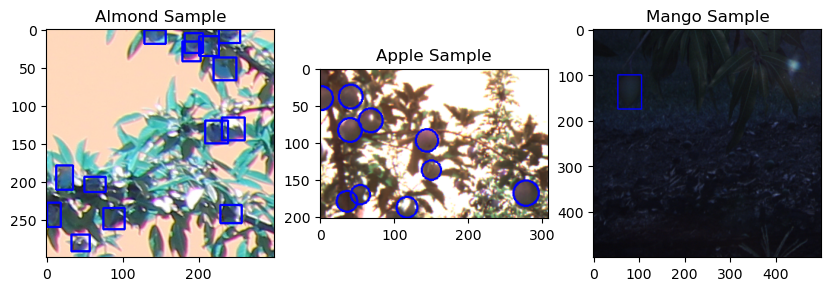

In [10]:
import cv2
import matplotlib.pyplot as plt

# randomly select a sample from each dataset along with its annotations to display how the data looks like
almond_sample = pd.Series(dataset["almonds"]["global_df"].picture_id.unique()).sample(1)
apple_sample = pd.Series(dataset["apples"]["global_df"].picture_id.unique()).sample(1)
mangoes_sample = pd.Series(dataset["mangoes"]["global_df"].picture_id.unique()).sample(1)
almond_sample = dataset["almonds"]["global_df"].loc[dataset["almonds"]["global_df"].picture_id == almond_sample.item()]
apple_sample = dataset["apples"]["global_df"].loc[dataset["apples"]["global_df"].picture_id == apple_sample.item()]
mangoes_sample = dataset["mangoes"]["global_df"].loc[dataset["mangoes"]["global_df"].picture_id == mangoes_sample.item()]

# draw ROI on random almond sample
almond_sample_img = cv2.imread(os.path.join("datasets/acfr-fruit-dataset/almonds/images", f"{almond_sample.picture_id.iloc[0]}.png"))
almond_sample.reset_index(inplace=True, drop=True)
for idx, row in almond_sample.iterrows():
    cv2.rectangle(almond_sample_img, (int(row.x), int(row.y)), (int(row.x) + int(row.dx), int(row.y) + int(row.dy)), color=(0,0,255), thickness=2)

# draw ROI on random apple sample
apple_sample_img = cv2.imread(os.path.join("datasets/acfr-fruit-dataset/apples/images", f"{apple_sample.picture_id.iloc[0]}.png"))
apple_sample.reset_index(inplace=True, drop=True)
for idx, row in apple_sample.iterrows():
    cv2.circle(apple_sample_img, (int(row["c-x"]), int(row["c-y"])), int(row.radius), color=(0,0,255), thickness=2)

# draw ROI on random mango example
mangoes_sample_img = cv2.imread(os.path.join("datasets/acfr-fruit-dataset/mangoes/images", f"{mangoes_sample.picture_id.iloc[0]}.png"))
mangoes_sample.reset_index(inplace=True, drop=True)
for idx, row in mangoes_sample.iterrows():
    cv2.rectangle(mangoes_sample_img, (int(row.x), int(row.y)), (int(row.x) + int(row.dx), int(row.y) + int(row.dy)), color=(0,0,255), thickness=2)

# display image
fig, ax = plt.subplots(1,3, figsize=(10,8))
ax[0].imshow(almond_sample_img)
ax[0].set_title("Almond Sample")
ax[1].imshow(apple_sample_img)
ax[1].set_title("Apple Sample")
ax[2].imshow(mangoes_sample_img)
ax[2].set_title("Mango Sample")
plt.show()

In order to further analyse the characteristics of samples in the datasets, each picture has been serialized into a multidimensional numpy array, which represents the grid of pixel values and their width, height, overall pixel count, and pixel mean have been extracted and stored in a dataframe.

In [12]:
from tqdm import tqdm
import os
import pandas as pd
import cv2

# Build Dataframe for all 3 datasets that contains image metadata to analyse image properties

apple_shapes = {
    "x": list(), # width
    "y": list(), # height
    "pixels": list(), # number of pixels
    "mean": list(), # average brightness of pixels across the image
    "picture_id": list() # file name
}
for picture_name in tqdm(os.listdir("datasets/acfr-fruit-dataset/apples/images")):
    pic = cv2.imread(os.path.join("datasets/acfr-fruit-dataset/apples/images", picture_name))
    apple_shapes["x"].append(pic.shape[1])
    apple_shapes["y"].append(pic.shape[0])
    apple_shapes["pixels"].append(pic.shape[0] * pic.shape[1])
    apple_shapes["picture_id"].append(picture_name[:-4])
    apple_shapes["mean"].append(pic.mean())
apple_shapes = pd.DataFrame(apple_shapes)

mango_shapes = {
    "x": list(),
    "y": list(),
    "pixels": list(),
    "mean": list(),
    "picture_id": list()
}
for picture_name in tqdm(os.listdir("datasets/acfr-fruit-dataset/mangoes/images")):
    pic = cv2.imread(os.path.join("datasets/acfr-fruit-dataset/mangoes/images", picture_name))
    mango_shapes["x"].append(pic.shape[1])
    mango_shapes["y"].append(pic.shape[0])
    mango_shapes["pixels"].append(pic.shape[0] * pic.shape[1])
    mango_shapes["picture_id"].append(picture_name[:-4])
    mango_shapes["mean"].append(pic.mean())
mango_shapes = pd.DataFrame(mango_shapes)

almond_shapes = {
    "x": list(),
    "y": list(),
    "pixels": list(),
    "mean": list(),
    "picture_id": list()
}
for picture_name in tqdm(os.listdir("datasets/acfr-fruit-dataset/almonds/images")):
    pic = cv2.imread(os.path.join("datasets/acfr-fruit-dataset/almonds/images", picture_name))
    almond_shapes["x"].append(pic.shape[1])
    almond_shapes["y"].append(pic.shape[0])
    almond_shapes["pixels"].append(pic.shape[0] * pic.shape[1])
    almond_shapes["picture_id"].append(picture_name[:-4])
    almond_shapes["mean"].append(pic.mean())
almond_shapes = pd.DataFrame(almond_shapes)

apple_shapes

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 620/620 [00:02<00:00, 238.40it/s]


,x,y,pixels,mean,picture_id
0,308,202,62216,97.444896,20130320T004615.614293.Cam6_51
1,308,202,62216,184.350623,20130320T013657.200420_21
2,308,202,62216,97.161363,20130320T013024.621036_62
3,308,202,62216,139.973153,20130320T004807.235605.Cam6_22
4,308,202,62216,212.991605,20130320T005104.572657.Cam6_14
...,...,...,...,...,...
1115,308,202,62216,166.783914,20130320T005423.814872.Cam6_12
1116,308,202,62216,112.020059,20130320T013321.386510_31
1117,308,202,62216,52.170096,20130320T005816.391049.Cam6_51
1118,308,202,62216,118.021908,20130320T005239.812601.Cam6_34


First up the distribution of the average image brightness has been analyzed. As a representative value for image brightness, the average brightness of each pixel across the image is used. In the box plot below, it can be observed that the apple dataset almost spans across the whole brightness spectrum with the median and mean both at around 120, suggesting, that it includes images with good and poor lighting conditions as well as day and night imagery. The mango datasets images on the other hand are extremely dark with the mean and median at around 25, with the maximum whisker of the plot also being below 50, however, this was calculated with a maximum constraint of $1.5 \mathrm{IQR}, \text{ with }\mathrm{IQR}=\mathrm{Q3}-\mathrm{Q1}$ and the rest are marked as outliers and depicted with circles. The brightness in the almond dataset is also fairly balanced with dark and bright images.

Text(0.5, 1.0, 'Image Brightness')

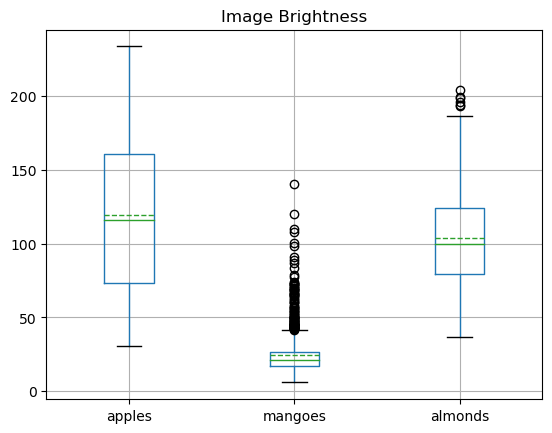

In [60]:
# Display Brightness distribution data for all 3 datasets
means = pd.DataFrame()
means["apples"] = apple_shapes["mean"]
means["mangoes"] = mango_shapes["mean"]
means["almonds"] = almond_shapes["mean"]
means.boxplot(showmeans=True, meanline=True)
plt.title("Image Brightness")

In addition to image brightness, the variance between the overall shape of the image has also been determined, to account for different aspect ratios and resolutions between images in each dataset. However, as expected because the data has been captured by the same sensor and entity for each dataset, there is no variance between images.

In [58]:
# calculate variance across the image shapes
variances = pd.DataFrame()
variances["apple_shapes"] = apple_shapes.var(numeric_only=True)
variances["almond_shapes"] = almond_shapes.var(numeric_only=True)
variances["mango_shapes"] = mango_shapes.var(numeric_only=True)
variances

,apple_shapes,almond_shapes,mango_shapes
x,0.000000,0.000000,0.000000
y,0.000000,0.000000,0.000000
pixels,0.000000,0.000000,0.000000
mean,2461.866215,1128.139201,198.633097


In [59]:
mango_shapes.x.unique(), mango_shapes.y.unique(), mango_shapes.pixels.unique() # Variance above comes from a library bottleneck, that pandas uses for faster calculation -> Numeric precision leads to rounding errors, this is not present on all machines though!

(array([500]), array([500]), array([250000]))

### Converting to Coco Format
As the dataset comes in no particular object detection standard format, it is converted to COCO format in this section. This enables the use of the popular COCO evaluator for object detection and allows for easier data loading and use, as many libraries such as pytorch have predefined handlers for the COCO dataset or dataset in the COCO format.

The COCO format provides that, the annotation data is stored in one large JSON-file for each split of the dataset. The JSON file looks as follows:
```JSON
{
    "info": {
        "year": "2021",
        "version": "1.0",
        "description": "Exported from FiftyOne",
        "contributor": "Voxel51",
        "url": "https://fiftyone.ai",
        "date_created": "2021-01-19T09:48:27"
    },
    "licenses": [
        {
          "url": "http://creativecommons.org/licenses/by-nc-sa/2.0/",
          "id": 1,
          "name": "Attribution-NonCommercial-ShareAlike License"
        },
        ...
    ],
    "categories": [
        ...
        {
            "id": 2,
            "name": "cat",
            "supercategory": "animal"
        },
        ...
    ],
    "images": [
        {
            "id": 0,
            "license": 1,
            "file_name": "<filename0>.<ext>",
            "height": 480,
            "width": 640,
            "date_captured": null
        },
        ...
    ],
    "annotations": [
        {
            "id": 0,
            "image_id": 0,
            "category_id": 2,
            "bbox": [260, 177, 231, 199],
            "segmentation": [...],
            "area": 45969,
            "iscrowd": 0
        },
        ...
    ]
}
```
It includes three main data objects:
- the categories, which include all information about the labels in the dataset
- the images, which includes information about the image sample, such as height, width, the file name etc.
- the annotations, which link the category / label to a particular image and include the coordinates of the bounding box (bbox), the area of the bounding box etc.

Thus, first the categories for the three datasets are defined. As each dataset only includes one label, each category has the id 0 with the corresponding name of the fruit as the label.

In [11]:
# Set categories for image labeling
categories_almond = [{
    "id": 0,
    "name": "almond",
    "supercategory": "fruit"
}]
categories_apple = [{
    "id": 0,
    "name": "apple",
    "supercategory": "fruit"
}]
categories_mangoes = [{
    "id": 0,
    "name": "mango",
    "supercategory": "fruit"
}]

Now, the image shapes and annotations can be converted into COCO format, by renaming the columns of the original dataframes to match the keys in the JSON of the COCO Format and exporting the dataframe into a dictionary with the record orientation. This results in one large list, with each record as a dictionary with the column names as keys. As python dictionaries are essentially an internal representation equivalent to JSON, this export can directly be attached to the COCO annotation dictionary, that is then serialized as a JSON object later on.

In [13]:
from typing import Dict, List, Union
def image_shapes_to_coco(shapes: pd.DataFrame) -> List[Dict[str, Union[int,str,None]]]: # function to convert the image properties to COCO Format
        shapes = shapes.copy() # Create Deep copy to prevent reference changes to the original data
        shapes["id"] = shapes.index
        shapes.rename(columns={
            "x": "width",
            "y": "height",
            "picture_id": "file_name"
        }, inplace=True) # rename columns to fit COCO Format
        shapes["license"] = None # Add additional columns
        shapes["date_captured"] = None
        shapes.file_name = shapes.file_name.astype(str)
        shapes.file_name = shapes.file_name.str.cat([".png" for _ in range(len(shapes.file_name))]) # rebuild filename from picture id
        shapes.drop(columns=["mean", "pixels"], inplace=True) # remove unnecessary columns
        return shapes.to_dict(orient="record") # export as dict which can be converted into JSON

In [14]:
image_shapes_to_coco(shapes=apple_shapes)

/tmp/ipykernel_1961/2568751409.py:15: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  return shapes.to_dict(orient="record")


[{'width': 308,
  'height': 202,
  'file_name': '20130320T004615.614293.Cam6_51.png',
  'id': 0,
  'license': None,
  'date_captured': None},
 {'width': 308,
  'height': 202,
  'file_name': '20130320T013657.200420_21.png',
  'id': 1,
  'license': None,
  'date_captured': None},
 {'width': 308,
  'height': 202,
  'file_name': '20130320T013024.621036_62.png',
  'id': 2,
  'license': None,
  'date_captured': None},
 {'width': 308,
  'height': 202,
  'file_name': '20130320T004807.235605.Cam6_22.png',
  'id': 3,
  'license': None,
  'date_captured': None},
 {'width': 308,
  'height': 202,
  'file_name': '20130320T005104.572657.Cam6_14.png',
  'id': 4,
  'license': None,
  'date_captured': None},
 {'width': 308,
  'height': 202,
  'file_name': '20130320T005323.051613.Cam6_21.png',
  'id': 5,
  'license': None,
  'date_captured': None},
 {'width': 308,
  'height': 202,
  'file_name': '20130320T004808.188000.Cam6_61.png',
  'id': 6,
  'license': None,
  'date_captured': None},
 {'width': 308,


The same procedure applies for the annotations, with the exception, that the index of the annotation and image (shapes) dataframes have to be linked together through an image_id and id column. In addition to that, the category id has to be set (to 0) for each annotation to reference the correct category / label and the bounding box coordinates have to be converted into rectangles for apples and then combined into a list instead of seperate columns for all three datasets. Last but not least, the area of the box is computed, unnecessary columns removed and the dataframe is exported in the same way as for the images.

In [15]:
import swifter
def annotations_to_coco(annotations: pd.DataFrame, shapes: pd.DataFrame, apples=False) -> List[Dict[str, Union[int, List[int]]]]: # function to convert dataset annotations to COCO Format
    annotations = annotations.copy() # Create Deep copy to prevent reference changes to the original data
    shapes = shapes.copy()
    shapes["image_id"] = shapes.index # Create foreign keys to reference data across dataframes / COCO Format Keys
    annotations["id"] = annotations.index
    annotations["picture_id"] = annotations.picture_id.astype(str)
    annotations = pd.merge(left=annotations, right=shapes[["picture_id", "image_id"]], how="left", on="picture_id") # Merge Annotations and Image Meta Data
    annotations["category_id"] = [0 for _ in range(len(annotations))] # Set category / label id
    if apples: # account for circular annotations for apples and convert them to boxes
        annotations["bbox"] = annotations.swifter.apply(lambda row: [int(row["c-x"]-row["radius"]), int(row["c-y"]-row["radius"]), int(2*row.radius), int(2*row.radius)], axis=1)
        annotations["area"] = 2*annotations.radius * 2*annotations.radius
        annotations.drop(columns=["picture_id", "#item", "label", "c-x", "c-y", "radius"], inplace=True) # drop old column names
    else:
        annotations["bbox"] = annotations.swifter.apply(lambda row: [int(row.x), int(row.y), int(row.dx), int(row.dy)], axis=1) # int conversion
        annotations["area"] = annotations.dx * annotations.dy
        annotations.drop(columns=["picture_id", "#item", "label", "x", "y", "dx", "dy"], inplace=True)
    annotations["iscrowd"] = 0
    annotations["iscrowd"] = 0
    return annotations.to_dict(orient="record")

In [16]:
annotations_to_coco(annotations=dataset['almonds']['global_df'], shapes=almond_shapes)

Pandas Apply:   0%|          | 0/4777 [00:00<?, ?it/s]

[{'id': 0,
  'image_id': 355,
  'category_id': 0,
  'bbox': [18, 37, 28, 32],
  'area': 896.0,
  'iscrowd': 0},
 {'id': 1,
  'image_id': 355,
  'category_id': 0,
  'bbox': [20, 20, 30, 34],
  'area': 1020.0,
  'iscrowd': 0},
 {'id': 2,
  'image_id': 355,
  'category_id': 0,
  'bbox': [0, 59, 34, 32],
  'area': 1088.0,
  'iscrowd': 0},
 {'id': 3,
  'image_id': 355,
  'category_id': 0,
  'bbox': [1, 264, 30, 32],
  'area': 960.0,
  'iscrowd': 0},
 {'id': 4,
  'image_id': 45,
  'category_id': 0,
  'bbox': [2, 105, 18, 26],
  'area': 468.0,
  'iscrowd': 0},
 {'id': 5,
  'image_id': 45,
  'category_id': 0,
  'bbox': [15, 111, 18, 26],
  'area': 468.0,
  'iscrowd': 0},
 {'id': 6,
  'image_id': 45,
  'category_id': 0,
  'bbox': [40, 111, 18, 22],
  'area': 396.0,
  'iscrowd': 0},
 {'id': 7,
  'image_id': 45,
  'category_id': 0,
  'bbox': [43, 89, 26, 26],
  'area': 676.0,
  'iscrowd': 0},
 {'id': 8,
  'image_id': 45,
  'category_id': 0,
  'bbox': [79, 51, 26, 26],
  'area': 676.0,
  'iscrowd'

Now for each dataset, annotations in COCO Format can be build using the above defined functions.

In [17]:
# Build COCO Format Dataset Representations
apple_coco_train = {
    "categories": categories_apple,
    "images": image_shapes_to_coco(apple_shapes.loc[apple_shapes.picture_id.isin(pd.read_csv("datasets/acfr-fruit-dataset/apples/sets/train.txt", names=["picture_id"]).picture_id.astype("string"))]),
    "annotations": annotations_to_coco(annotations=dataset["apples"]["global_df"].loc[dataset["apples"]["global_df"].picture_id.isin(pd.read_csv("datasets/acfr-fruit-dataset/apples/sets/train.txt", names=["picture_id"]).picture_id.astype("string"))], shapes=apple_shapes.loc[apple_shapes.picture_id.isin(pd.read_csv("datasets/acfr-fruit-dataset/apples/sets/train.txt", names=["picture_id"]).picture_id.astype("string"))], apples=True),
    "licenses": None,
    "info": None
}
apple_coco_test = {
    "categories": categories_apple,
    "images": image_shapes_to_coco(apple_shapes.loc[apple_shapes.picture_id.isin(pd.read_csv("datasets/acfr-fruit-dataset/apples/sets/test.txt", names=["picture_id"]).picture_id.astype("string"))]),
    "annotations": annotations_to_coco(annotations=dataset["apples"]["global_df"].loc[dataset["apples"]["global_df"].picture_id.isin(pd.read_csv("datasets/acfr-fruit-dataset/apples/sets/test.txt", names=["picture_id"]).picture_id.astype("string"))], shapes=apple_shapes.loc[apple_shapes.picture_id.isin(pd.read_csv("datasets/acfr-fruit-dataset/apples/sets/test.txt", names=["picture_id"]).picture_id.astype("string"))], apples=True),
    "licenses": None,
    "info": None
}
apple_coco_val = {
    "categories": categories_apple,
    "images": image_shapes_to_coco(apple_shapes.loc[apple_shapes.picture_id.isin(pd.read_csv("datasets/acfr-fruit-dataset/apples/sets/val.txt", names=["picture_id"]).picture_id.astype("string"))]),
    "annotations": annotations_to_coco(annotations=dataset["apples"]["global_df"].loc[dataset["apples"]["global_df"].picture_id.isin(pd.read_csv("datasets/acfr-fruit-dataset/apples/sets/val.txt", names=["picture_id"]).picture_id.astype("string"))], shapes=apple_shapes.loc[apple_shapes.picture_id.isin(pd.read_csv("datasets/acfr-fruit-dataset/apples/sets/val.txt", names=["picture_id"]).picture_id.astype("string"))], apples=True),
    "licenses": None,
    "info": None
}
almonds_coco_train = {
    "categories": categories_almond,
    "images": image_shapes_to_coco(almond_shapes.loc[almond_shapes.picture_id.isin(pd.read_csv("datasets/acfr-fruit-dataset/almonds/sets/train.txt", names=["picture_id"]).picture_id.astype("string"))]),
    "annotations": annotations_to_coco(annotations=dataset["almonds"]["global_df"].loc[dataset["almonds"]["global_df"].picture_id.isin(pd.read_csv("datasets/acfr-fruit-dataset/almonds/sets/train.txt", names=["picture_id"]).picture_id.astype("string"))], shapes=almond_shapes.loc[almond_shapes.picture_id.isin(pd.read_csv("datasets/acfr-fruit-dataset/almonds/sets/train.txt", names=["picture_id"]).picture_id.astype("string"))]),
    "licenses": None,
    "info": None
}
almonds_coco_test = {
    "categories": categories_almond,
    "images": image_shapes_to_coco(almond_shapes.loc[almond_shapes.picture_id.isin(pd.read_csv("datasets/acfr-fruit-dataset/almonds/sets/test.txt", names=["picture_id"]).picture_id.astype("string"))]),
    "annotations": annotations_to_coco(annotations=dataset["almonds"]["global_df"].loc[dataset["almonds"]["global_df"].picture_id.isin(pd.read_csv("datasets/acfr-fruit-dataset/almonds/sets/test.txt", names=["picture_id"]).picture_id.astype("string"))], shapes=almond_shapes.loc[almond_shapes.picture_id.isin(pd.read_csv("datasets/acfr-fruit-dataset/almonds/sets/test.txt", names=["picture_id"]).picture_id.astype("string"))]),
    "licenses": None,
    "info": None
}
almonds_coco_val = {
    "categories": categories_almond,
    "images": image_shapes_to_coco(almond_shapes.loc[almond_shapes.picture_id.isin(pd.read_csv("datasets/acfr-fruit-dataset/almonds/sets/val.txt", names=["picture_id"]).picture_id.astype("string"))]),
    "annotations": annotations_to_coco(annotations=dataset["almonds"]["global_df"].loc[dataset["almonds"]["global_df"].picture_id.isin(pd.read_csv("datasets/acfr-fruit-dataset/almonds/sets/val.txt", names=["picture_id"]).picture_id.astype("string"))], shapes=almond_shapes.loc[almond_shapes.picture_id.isin(pd.read_csv("datasets/acfr-fruit-dataset/almonds/sets/val.txt", names=["picture_id"]).picture_id.astype("string"))]),
    "licenses": None,
    "info": None
}
mangoes_coco_train = {
    "categories": categories_mangoes,
    "images": image_shapes_to_coco(mango_shapes.loc[mango_shapes.picture_id.isin(pd.read_csv("datasets/acfr-fruit-dataset/mangoes/sets/train.txt", names=["picture_id"]).picture_id.astype("string"))]),
    "annotations": annotations_to_coco(annotations=dataset["mangoes"]["global_df"].loc[dataset["mangoes"]["global_df"].picture_id.isin(pd.read_csv("datasets/acfr-fruit-dataset/mangoes/sets/train.txt", names=["picture_id"]).picture_id.astype("string"))], shapes=mango_shapes.loc[mango_shapes.picture_id.isin(pd.read_csv("datasets/acfr-fruit-dataset/mangoes/sets/train.txt", names=["picture_id"]).picture_id.astype("string"))]),
    "licenses": None,
    "info": None
}
mangoes_coco_test = {
    "categories": categories_mangoes,
    "images": image_shapes_to_coco(mango_shapes.loc[mango_shapes.picture_id.isin(pd.read_csv("datasets/acfr-fruit-dataset/mangoes/sets/test.txt", names=["picture_id"]).picture_id.astype("string"))]),
    "annotations": annotations_to_coco(annotations=dataset["mangoes"]["global_df"].loc[dataset["mangoes"]["global_df"].picture_id.isin(pd.read_csv("datasets/acfr-fruit-dataset/mangoes/sets/test.txt", names=["picture_id"]).picture_id.astype("string"))], shapes=mango_shapes.loc[mango_shapes.picture_id.isin(pd.read_csv("datasets/acfr-fruit-dataset/mangoes/sets/test.txt", names=["picture_id"]).picture_id.astype("string"))]),
    "licenses": None,
    "info": None
}
mangoes_coco_val = {
    "categories": categories_mangoes,
    "images": image_shapes_to_coco(mango_shapes.loc[mango_shapes.picture_id.isin(pd.read_csv("datasets/acfr-fruit-dataset/mangoes/sets/val.txt", names=["picture_id"]).picture_id.astype("string"))]),
    "annotations": annotations_to_coco(annotations=dataset["mangoes"]["global_df"].loc[dataset["mangoes"]["global_df"].picture_id.isin(pd.read_csv("datasets/acfr-fruit-dataset/mangoes/sets/val.txt", names=["picture_id"]).picture_id.astype("string"))], shapes=mango_shapes.loc[mango_shapes.picture_id.isin(pd.read_csv("datasets/acfr-fruit-dataset/mangoes/sets/val.txt", names=["picture_id"]).picture_id.astype("string"))]),
    "licenses": None,
    "info": None
}

Pandas Apply:   0%|          | 0/4673 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/554 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/538 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3185 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/797 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/795 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5186 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/947 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/932 [00:00<?, ?it/s]

However, only converting annotations is not enough. The dataset also has to be in a specified directory structure. This structure provides, that each split has its own directory, with the annotation JSON for each split on the toplevel of the directory. To achieve this, the following function creates a "coco" directory in the folder of the given dataset, creates the split subfolders, copies all required images into their corresponding folders and exports the annotation dictionaries as JSON and writes them to disk at the required location.

In [18]:
from shutil import copy
import json

def create_coco_dir_struct(label_json_train: dict, label_json_test: dict, label_json_val: dict, fruit: str): # Create Coco Format directory structure
    # automatically create dirs if not exist
    os.makedirs(name=f"datasets/acfr-fruit-dataset/{fruit}/coco/train", exist_ok=True)
    os.makedirs(name=f"datasets/acfr-fruit-dataset/{fruit}/coco/test", exist_ok=True)
    os.makedirs(name=f"datasets/acfr-fruit-dataset/{fruit}/coco/val", exist_ok=True)

    for image_struct in label_json_train["images"]:
        copy(src=f"datasets/acfr-fruit-dataset/{fruit}/images/{image_struct['file_name']}", dst=f"datasets/acfr-fruit-dataset/{fruit}/coco/train/")
    for image_struct in label_json_test["images"]:
        copy(src=f"datasets/acfr-fruit-dataset/{fruit}/images/{image_struct['file_name']}", dst=f"datasets/acfr-fruit-dataset/{fruit}/coco/test/")
    for image_struct in label_json_val["images"]:
        copy(src=f"datasets/acfr-fruit-dataset/{fruit}/images/{image_struct['file_name']}", dst=f"datasets/acfr-fruit-dataset/{fruit}/coco/val/")

    open(f"datasets/acfr-fruit-dataset/{fruit}/coco/train.json", "w+").write(json.dumps(label_json_train))
    open(f"datasets/acfr-fruit-dataset/{fruit}/coco/test.json", "w+").write(json.dumps(label_json_test))
    open(f"datasets/acfr-fruit-dataset/{fruit}/coco/val.json", "w+").write(json.dumps(label_json_val))

In [19]:
label_jsons = {
    "almonds": [almonds_coco_train, almonds_coco_val, almonds_coco_test],
    "apples": [apple_coco_train, apple_coco_val, apple_coco_test],
    "mangoes": [mangoes_coco_train, mangoes_coco_val, mangoes_coco_test],
}
# Create Directories
for fruit, labels in label_jsons.items():
    create_coco_dir_struct(label_json_train=labels[0], label_json_test=labels[2], label_json_val=labels[1], fruit=fruit)

Now the dataset is available in COCO format and the suite of available COCO tools can be used for a comparable evaluation and training process between different papers and publications.

### Pytorch Dataloader & Dataset
Before the dataset can be used to train a model or to run inference, a pytorch dataset has to be defined for it. Thus, the included CocoDetection dataset class of torchvision, which is a module of pytorch, is extended, such that it returns each image and the corresponding annotation in a format, a vision transformer can understand. The primary extension that has to be made to the standard CocoDetection dataset class, is that the dataset has to account for a custom model specific feature extractor / image processor, which is in charge of preparing the input features for its corresponding vision models (Image Processor, n.d.). This includes resizing and normalization of the input image, as well as padding the image to fit the models input scheme. Thus the ``__getitem__`` method is overwritten to call the feature extractor before returning the ``pixel_values`` and the target for the current data item.

In [3]:
import torchvision

# define Torch Dataset in COCO Format
class CocoDetection(torchvision.datasets.CocoDetection):

    def __init__(self, img_folder, feature_extractor, train=True):
        annotations_path = os.path.join(img_folder, "../train.json" if train else "../val.json")
        super(CocoDetection, self).__init__(img_folder, annotations_path)
        self.feature_extractor = feature_extractor

    def __getitem__(self, idx):
        # read image and target
        img, target = super(CocoDetection, self).__getitem__(idx)

        # preprocess image and target (resizing + normalization), such that it can be used by the model
        image_id = self.ids[idx]
        target = {"image_id": image_id, 'annotations': target}
        encoding = self.feature_extractor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["labels"][0]

        return pixel_values, target

## Models
In this paper two Vision Transformers for Object Detection, namely Yolos and Detr will be Fine-Tuned on the acf-fruit-dataset. Their performance is later evaluated against multiple state-of-the-art Models for applications in orchards. To directly asses detection performance, the Faster-R-CNN ZFnet, VGG16 and a pixel-wise CNN adapted by the authors of the dataset and their reported results are used to form a comparison baseline. As a second evaluation step, the real-time performance of both vision transformers is discussed by comparing them to not only the inference times of the mentioned Faster-R-CNN derivatives but also taking multiple state-of-the-art YOLO models into account, that have been developed to perform well in green citrus, orange or dragon fruit orchards. As this comparison focuses on the average inference time per image, the actual dataset objective is not relevant for this comparison. Thus, in the following chapter, Faster-R-CNN, YOLO and Vision Transformers along with their most important derivatives are introduced and YOLOS and Detr are also Fine-Tuned.

### Faster-R-CNN
The Faster-R-CNN network consists of two-stage detection process. First, a Region Proposal Network (RPN) predicts Regions of Interest (RoI) along with an objectness score. These predictions are then passed on to an image classifier, which classifies the objects in the proposed RoI (Ren et al., 2016). The Region Proposal Network is a convolutional neural network, that shares a set of convolutional layers with the image classifier. It works by sliding a small network over the convolutional feature map output by the last shared convolutional layer. Each sliding window is then mapped to a lower-dimensional feature, which is fed into two sibling fully connected layers (Ren et al., 2016). One layer is a box regression layer, that predicts the coordinates of a (rectangular) bounding box and the other is a box-classification layer, which predicts an object score for each available label. At each sliding window location multiple region proposals are predicted (Ren et al., 2016). The extracted RoIs are then fed into another Object Detection / Image Classification network such as Fast-R-CNN which poses an end-to-end Convolutional Neural Network image classifier, that takes RoIs from a region proposal module (Ren et al., 2016). Thus Fast-R-CNNs performance is directly dependent on how well the region proposal network performs.

#### ZFnet and VGG16
In terms of Faster-R-CNN, ZFnet and VGG16 refer to the derivatives of Fast-R-CNN, that are used in the second stage of the Faster-R-CNN model. Both are fully convolutional neural networks of a different size. VGG16 is a 16 layer deep network, that can perform classification tasks on 224x224 pixel RGB images for up to 1000 classes with high level accuracy (Simonyan & Zisserman, 2015). ZFnet is a smaller convolutional neural network, consisting of 5 convolutional layers which originally aimed at visualising how convolutional networks work and what features they extracted (Zeiler & Fergus, 2013), however it can also be used as a simple image classifier.

### YOLO
YOLO, or You Only Look Once, is an object detection network, that aims to achieve unified, real-time object detection through unifying the separate object detection steps into one single neural network (Redmon et al., 2016). It achieves this, by modelling the detection task as a regression problem. It first divides the image into a SxS grid. Then it uses each grid cell to predict bounding boxes along with confidence scores that describe how confident the model is that a box contains an object. Simultaneously, it predicts a class probability map, where class probabilities are predicted for each grid cell. The probabilities of the classes are then multiplied with the confidence scores of each bounding box to retrieve class-specific bounding box confidence scores that encode both the probability of the class, and how well the predicted box fits the object. The grid cell at the center of each bounding box is responsible for detecting the object. In reality, this is achieved by using 24 convolutional layers, followed by two fully connected layers (Redmon et al., 2016). To this day, YOLO models and their revisions achieve state-of-the-art realtime object detection performance (Koirala et al., 2019; Zhang et al., 2022).

### Vision Transformer
Vision Transformer aim to bring the dominant and outstanding performance of Transformer models from the domain of Natural Language Processing to computer vision tasks (Dosovitskiy et al., 2021). Primarily this includes advantages such as:
- Network pre-training with efficient Fine-Tuning on downstream tasks
- Computational efficiency
- scalability
- easy adaptability

It aims at re-using the original Transformer architecture proposed by Vaswani et al. as much as possible, which takes a 1D sequence of token embeddings as input (Vaswani et al., 2017). The input is then processed by an Encoder, which consists of multiple layers comprised  of (Vaswani et al., 2017):
- a Multi-Head Attention module, which runs multiple attention layers in parallel to be able to jointly attend to information accross different representation subspaces and positions,
- residual connections to retain important information, such as positional data
- a Feed Forward network, which acts the same as two convolutions with kernel size 1

The resulting representation is then used by a Decoder to auto-regressively generate a text sequence. However, the architecture of the decoder is not outlined, as it is not needed in Vision Transformers.

As this architecture is designed to work with sequential inputs, it can't work with images out of the box. Therefore, Dosovitskiy et al. proposed a method to map an image to a sequential representation. Each image $x \in \mathbb{R}^{H \times W \times C}$ is reshaped into a sequence of flattened 2D-patches $x_p \in \mathbb{R}^{N\times (P^2*C}$, where $H$ marks the image height, $W$ the image width, $C$ is the number of channels, $P$ being the width and height of the patches and $N = \frac{HW}{P^2}$ is the number of patches, which simultaneously marks the effective input sequence length to the transformer encoder (Dosovitskiy et al., 2021). However, as the transformer uses a fixed hidden size $d$ as its latent representation, thus each flattened patch has to be mapped to d dimensions, which is achieved with a trainable linear projection. The output of this projection is referred to as the patch embeddings (Dosovitskiy et al., 2021). A learned positional embedding is then added to the patch embeddings similar to the positional embedding of the original transformer model, to form the complete model input. In addition, the transformer encoder is also extended to include a prepended classification token similar to what is used in the BERT Transformer, whose state at the output of the encoder serves as the image representation (Dosovitskiy et al., 2021). A simple fully connected classification head can then be attached to this classification token to take care of image classification.
As an alternative to the raw image patch input, Dosovitskiy et al. also proposed a hybrid architecture that builds the model input from CNN feature maps, by applying the patch embedding projection to patches from the extracted CNN feature map directly (Dosovitskiy et al., 2021). The classification input embedding, and the position embeddings are added as described above as well.
As an alternative to the raw image patch input, Dosovitskiy et al. also proposed a hybrid architecture that builds the model input from CNN feature maps, by applying the patch embedding projection to patches from the extracted CNN feature map directly (Dosovitskiy et al., 2021). The classification input embedding, and the position embeddings are added as described above as well.

The model showed to have similar image classification performance, while being scalable to different sizes and taking significantly less ressources to train then the Faster-R-CNN baseline (Dosovitskiy et al., 2021). However, the standard model can only be used for image classification and not object detection, rendering the original model unfeasable for the task presented in this paper. Therefore, two dervatives of the original Vision Transformer are used, YOLOS and DETR.

## DETR
DETR is a End-to-End Object Detection Transformer, that aims at performing direct set predictions instead of solving the task indirectly through region proposals and classification tasks, all while being easy to implement and ressource efficient (Carion et al., 2020). The model consists of three main parts:
1. A conventional CNN backbone
2. A Transformer encoder-decoder architecture
3. A prediction Forward Neural Network

The input image is first passed through the conventional Convolutional Neural Network, which generates a lower-resolution activation map $f \in \mathbb{R}^{C\times H\times W}$, typically with $C=2048$ and $H,W = \frac{H_0}{32}, \frac{W_0}{32}$. The number of channels $C$ is then further reduced by another $1\times 1$ convolution to a smaller dimension $d$, which matches the fixed hidden size $d$ of the transformer encoder-decoder (Carion et al., 2020). As in the original Vision Transformer, the feature map is now mapped to a sequential input. DETR achieves this, by collapsing the spatial dimensions of the feature map into one dimension, resulting in a $d\times HW$ sequential feature map. Fixed positional encodings are then added to the feature map, and it is passed on to the Transformer encoder (Carion et al., 2020). The transformer encoder itself remains unchanged compared to the original one proposed by (Vaswani et al., 2017). The Transformer decoder architecture also remains unchanged compared to the original, however, instead of using an autoregressive approach, DETR decodes $N$ objects in parallel at each decoder layer. It achieves this, by feeding $N$ learnt positional encodings, that Carion et al. refer to as *object queries*, into the Transformer decoder and adding them to each attention layer. As the decoder is permutation-invariant, all $N$ object queries have to be different to generate different outputs (Carion et al., 2020). The object queries are then transformed into an output embedding by the decoder, while attending to the encoder output in the encoder-decoder attention layer of the transformer decoder. The output embedding is then passed on to a Forward Neural Network, which independently predicts box coordinates and class labels, resulting in $N$, with $N > \mathrm{number\_of\_classes}$, final predictions. To account for positions where no class or object might be present, an additional special class label is added to the available classes that represents that no object is detected within a slot (Carion et al., 2020).

In order to Fine-Tune DETR on the acfr-fruit-dataset, a custom collate function has to be defined, that is passed to the torch Dataloader. This function converts each batch into the data structure, the model expects as input. For Detr, this includes padding the image and generating a pixel mask. The pixel mask is used if segmentation heads instead of detection heads are used.

In [7]:
def collate_fn(batch): # Custom collate function to convert batch to Detr Format
  pixel_values = [item[0] for item in batch]
  encoding = feature_extractor.pad(pixel_values, return_tensors="pt") # pad and create pixel mask
  labels = [item[1] for item in batch]
  batch = {}
  batch['pixel_values'] = encoding['pixel_values']
  batch['pixel_mask'] = encoding['pixel_mask']
  batch['labels'] = labels
  return batch

Then the Detr model is defined as a LightningModule by creating a Wrapper class extending pytorch lightnings LightningModule and mapping the Detr implementation of Huggingface to the functions of the LightningModule. This allows the training using pytorch lightning instead of regular pytorch, wich adds the benefits of automatic logging to Tensorboard and the usage of a unified Trainer. This eliminates the necessity of defining a custom validation and training loop. Instead, a common step is defined, which handles the prediction and loss computation for both the validation and training loops and a validation and training step is defined, which return the losses to the Trainer and define the Tensorboard logging topics for the variables of interest such as the current loss values. Last but not least, the optimizer to be used is defined, as proposed by the authors of Detr (Carion et al., 2020), the torchs AdamW optimizer is used which extends the popular Adam optimizer with weight decay functionality.

In [8]:
from transformers import DetrForObjectDetection
import pytorch_lightning as pl
import torch

# define Detr VIT as a Lightning Module, so it can be trained with pytorch lightning
class Detr(pl.LightningModule):
     def __init__(self, lr, lr_backbone, weight_decay):
         super().__init__()
         # replace COCO classification head with custom head
         # we specify the "no_timm" variant here to not rely on the timm library
         # for the convolutional backbone
         self.model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50",
                                                             revision="no_timm",
                                                             num_labels=1,
                                                             ignore_mismatched_sizes=True) # init model

         self.lr = lr
         self.lr_backbone = lr_backbone
         self.weight_decay = weight_decay

     def forward(self, pixel_values, pixel_mask):
       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

       return outputs

     def common_step(self, batch, batch_idx):
       pixel_values = batch["pixel_values"]
       pixel_mask = batch["pixel_mask"]
       labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

       loss = outputs.loss
       loss_dict = outputs.loss_dict

       return loss, loss_dict

     def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
          self.log("train_" + k, v.item())

        return loss

     def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("validation_loss", loss)
        for k,v in loss_dict.items():
          self.log("validation_" + k, v.item())

        return loss

     def configure_optimizers(self):
        param_dicts = [
              {"params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
              {
                  "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                  "lr": self.lr_backbone,
              },
        ] # Configure Parameters for the CNN Backbone of Detr
        optimizer = torch.optim.AdamW(param_dicts, lr=self.lr,
                                  weight_decay=self.weight_decay) # initialize optimizer

        return optimizer

     def train_dataloader(self):
        return train_dataloader

     def val_dataloader(self):
        return val_dataloader

### Apples

Now, the only thing that remains is to load Detr image processor / feature extractor, initialise the datasets for the current task, in this case for the apple subset.

In [49]:
from transformers import DetrImageProcessor
from torch.utils.data import DataLoader

# init dataset and feature extractor
feature_extractor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
train_dataset = CocoDetection(img_folder="datasets/acfr-fruit-dataset/apples/coco/train", feature_extractor=feature_extractor)
val_dataset = CocoDetection(img_folder="datasets/acfr-fruit-dataset/apples/coco/val", feature_extractor=feature_extractor, train=False)
train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=12, shuffle=True)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=12)
batch = next(iter(train_dataloader))
batch.keys() # check batch keys

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


dict_keys(['pixel_values', 'pixel_mask', 'labels'])

Initialize the model and call the ``fit()`` method of the pytorch lightning Trainer, which will automatically start model training. The model is initialized from a pre-trained DETR checkpoint on the COCO 2017 object detection dataset. All training hyperparameters remain unchanged to the original proposal of Carion et al. and no Hyperparameter tuning is done, except for increasing the maximum number of optimisation steps to 1000, as training with the original proposition of 300 showed significant underfitting behavior. The model is thus trained on an Nvidia Tesla T4 GPU for 1000 optimization steps, which takes approximately 30mins in total.

In [51]:
from pytorch_lightning import Trainer
# Train Detr
model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)

max_steps = 1000

trainer = Trainer(max_steps=max_steps, gradient_clip_val=0.1)
trainer.fit(model)

Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                   | Params
-------------------------------------------------
0 | model | DetrForObjectDetection | 41.5 M
-------------------------------------------------
18.0 M    Trainable params
23.5 M    Non-trainable params
41.5 M    Tot

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.


In [52]:
torch.save(model.state_dict(), "models/detr_apples_v1.pt") # save model for reuse

After training has completed, the model is saved for reuse and reproducability and the models predictions on a random sample along with the corresponding ground truth is visualised. The same procedure is repeated for Almonds and Mangoes without significant changes.

/opt/conda/envs/pytorch/lib/python3.9/site-packages/transformers/models/detr/image_processing_detr.py:886: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
/opt/conda/envs/pytorch/lib/python3.9/site-packages/transformers/models/detr/image_processing_detr.py:780: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(


DetrObjectDetectionOutput(loss=None, loss_dict=None, logits=tensor([[[-1.5023, -0.0542],
         [-0.5519, -0.8863],
         [-2.7177,  0.5763],
         [-1.3145,  0.4309],
         [-0.7623,  0.0162],
         [-1.9191,  0.4033],
         [-1.7564,  0.3799],
         [-0.6828, -1.2782],
         [-0.4672, -0.2590],
         [ 0.6040, -1.4746],
         [-3.3978,  1.6881],
         [-2.3168,  0.3080],
         [-3.2332,  1.8499],
         [-3.4193,  1.6290],
         [-3.0391,  1.8341],
         [-0.8370, -0.4017],
         [-0.4624, -0.4625],
         [-1.8729,  1.3773],
         [-1.9056,  1.0051],
         [-2.5642,  1.2216],
         [-4.2879,  2.7057],
         [-3.4813,  2.0125],
         [-1.4913,  0.6702],
         [-4.4261,  2.6772],
         [ 1.2614, -2.3505],
         [-2.4350,  0.9955],
         [-1.2127,  0.0705],
         [-2.0040, -0.0502],
         [ 0.5708, -1.1972],
         [ 0.6787, -1.0093],
         [-2.2410,  0.5560],
         [-1.0937, -0.3211],
         [-3

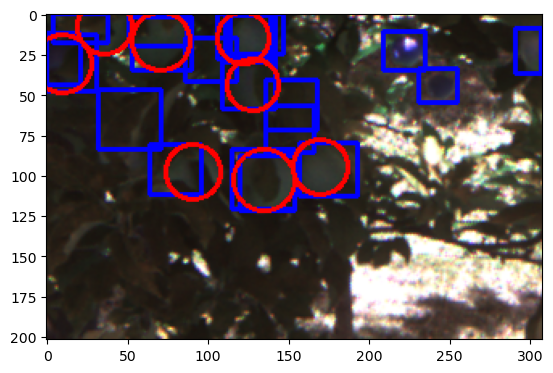

In [58]:
from transformers import AutoImageProcessor, AutoModelForObjectDetection
import torch
from PIL import Image
import requests
import numpy as np
import cv2

# Visualise prediction and ground truth on a random sample

val_id = np.random.randint(0, len(val_dataset))

file_name = val_dataset.coco.loadImgs(
                                    val_dataset[val_id][1]["image_id"].item())[0]['file_name']


image = Image.open(os.path.join("datasets/acfr-fruit-dataset/apples/coco/val",
                           file_name
                   ))
image_processor = AutoImageProcessor.from_pretrained("facebook/detr-resnet-50")

cats = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}

val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=1)
pixel_values, pixel_mask, labels = list(iter(val_dataloader))[val_id].values()

outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)


# convert outputs (bounding boxes and class logits) to COCO API
target_sizes = torch.tensor([image.size[::-1]])
results = image_processor.post_process_object_detection(outputs, threshold=0.5, target_sizes=target_sizes)[
     0
]

image = np.array(image)
image = image[:,:,::-1].copy()
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]): # draw prediction
     box = [round(i, 2) for i in box.tolist()]
     print(
         f"Detected {id2label[label.item()]} with confidence "
         f"{round(score.item(), 3)} at location {box}"
     )
     cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), color=(0,0,255), thickness=2)

for idx, row in dataset["apples"]["global_df"].loc[dataset["apples"]["global_df"].picture_id == file_name[:-4]].iterrows(): # draw annotations
    cv2.circle(image, (int(row["c-x"]), int(row["c-y"])), int(row.radius), color=(255,0,0), thickness=2)

plt.imshow(image)

#### Almonds

In [60]:
from transformers import DetrImageProcessor

feature_extractor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
train_dataset = CocoDetection(img_folder="datasets/acfr-fruit-dataset/almonds/coco/train", feature_extractor=feature_extractor)
val_dataset = CocoDetection(img_folder="datasets/acfr-fruit-dataset/almonds/coco/val", feature_extractor=feature_extractor, train=False)
train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=12, shuffle=True)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=12)
batch = next(iter(train_dataloader))
batch.keys()

/opt/conda/envs/pytorch/lib/python3.9/site-packages/transformers/models/detr/image_processing_detr.py:780: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(
/opt/conda/envs/pytorch/lib/python3.9/site-packages/transformers/models/detr/image_processing_detr.py:886: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


dict_keys(['pixel_values', 'pixel_mask', 'labels'])

In [61]:
from pytorch_lightning import Trainer
model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)

max_steps = 1000

trainer = Trainer(max_steps=max_steps, gradient_clip_val=0.1)
trainer.fit(model)

Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                   | Params
-------------------------------------------------
0 | model | DetrForObjectDetection | 41.5 M
-------------------------------------------------
18.0 M    Trainable params
23.5 M    Non-trainable params
41.5 M    Tot

Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/envs/pytorch/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/conda/envs/pytorch/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/conda/envs/pytorch/lib/python3.9/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (35) is smaller than the logging interval Trainer(log_e

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.


In [62]:
torch.save(model.state_dict(), "models/detr_almonds_v1.pt")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


DetrObjectDetectionOutput(loss=None, loss_dict=None, logits=tensor([[[-1.1819,  1.4676],
         [-3.1141,  1.7593],
         [-1.0492,  1.0742],
         [-3.2896,  1.4333],
         [-3.0169,  0.9654],
         [-2.8712,  1.4123],
         [-2.5567,  1.4691],
         [-2.4318,  2.1766],
         [-2.7787,  1.4407],
         [-3.0860,  1.9875],
         [-2.8570,  1.7201],
         [ 0.2617, -0.4945],
         [-2.6143,  2.3524],
         [-2.4785,  2.2694],
         [-2.9263,  1.3080],
         [-2.3970,  2.4236],
         [-3.3014,  1.9944],
         [-3.1632,  1.8737],
         [-2.4271,  1.9106],
         [-2.8477,  1.8154],
         [ 1.1873, -1.6236],
         [-2.4795,  2.0186],
         [-3.8380,  2.9723],
         [-1.5974,  1.3463],
         [ 0.0809, -1.2773],
         [-2.8013,  2.0916],
         [-2.3349,  2.0616],
         [-1.5445,  1.1221],
         [-3.1585,  0.9438],
         [-3.0991,  2.5305],
         [-1.5264,  1.5266],
         [-2.1218,  0.3747],
         [-2

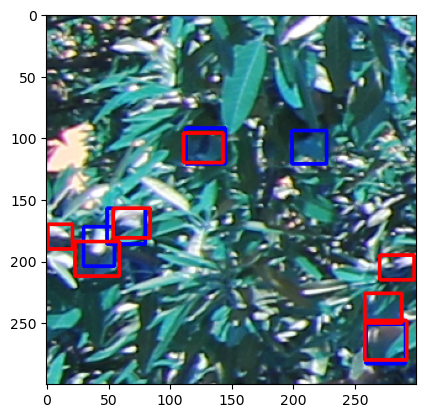

In [63]:
from transformers import AutoImageProcessor, AutoModelForObjectDetection
import torch
from PIL import Image
import requests
import numpy as np
import cv2

val_id = np.random.randint(0, len(val_dataset))

file_name = val_dataset.coco.loadImgs(
                                    val_dataset[val_id][1]["image_id"].item())[0]['file_name']


image = Image.open(os.path.join("datasets/acfr-fruit-dataset/almonds/coco/val",
                           file_name
                   ))
image_processor = AutoImageProcessor.from_pretrained("facebook/detr-resnet-50")

cats = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}

val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=1)
pixel_values, pixel_mask, labels = list(iter(val_dataloader))[val_id].values()

outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)


# convert outputs (bounding boxes and class logits) to COCO API
target_sizes = torch.tensor([image.size[::-1]])
results = image_processor.post_process_object_detection(outputs, threshold=0.5, target_sizes=target_sizes)[
     0
]

image = np.array(image)
image = image[:,:,::-1].copy()
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
     box = [round(i, 2) for i in box.tolist()]
     print(
         f"Detected {id2label[label.item()]} with confidence "
         f"{round(score.item(), 3)} at location {box}"
     )
     cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), color=(0,0,255), thickness=2)

for idx, row in dataset["almonds"]["global_df"].loc[dataset["almonds"]["global_df"].picture_id == file_name[:-4]].iterrows():
    cv2.rectangle(image, (int(row.x), int(row.y)), (int(row.x) + int(row.dx), int(row.y) + int(row.dy)), color=(255,0,0), thickness=2)

plt.imshow(image)

### Mangoes

In [64]:
from transformers import DetrImageProcessor

feature_extractor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
train_dataset = CocoDetection(img_folder="datasets/acfr-fruit-dataset/mangoes/coco/train", feature_extractor=feature_extractor)
val_dataset = CocoDetection(img_folder="datasets/acfr-fruit-dataset/mangoes/coco/val", feature_extractor=feature_extractor, train=False)
train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=12, shuffle=True)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=12)
batch = next(iter(train_dataloader))
batch.keys()

/opt/conda/envs/pytorch/lib/python3.9/site-packages/transformers/models/detr/image_processing_detr.py:780: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(
/opt/conda/envs/pytorch/lib/python3.9/site-packages/transformers/models/detr/image_processing_detr.py:886: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


dict_keys(['pixel_values', 'pixel_mask', 'labels'])

In [65]:
from pytorch_lightning import Trainer
model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)

max_steps = 1000

trainer = Trainer(max_steps=max_steps, gradient_clip_val=0.1)
trainer.fit(model)

Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                   | Params
-------------------------------------------------
0 | model | DetrForObjectDetection | 41.5 M
-------------------------------------------------
18.0 M    Trainable params
23.5 M    Non-trainable params
41.5 M    Tot

Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/envs/pytorch/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/conda/envs/pytorch/lib/python3.9/site-packages/transformers/models/detr/image_processing_detr.py:886: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(
/opt/conda/envs/pytorch/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `D

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/opt/conda/envs/pytorch/lib/python3.9/site-packages/pytorch_lightning/utilities/data.py:77: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 10. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.


In [66]:
torch.save(model.state_dict(), "models/detr_mangoes_v1.pt")

/opt/conda/envs/pytorch/lib/python3.9/site-packages/transformers/models/detr/image_processing_detr.py:886: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
/opt/conda/envs/pytorch/lib/python3.9/site-packages/transformers/models/detr/image_processing_detr.py:780: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(


Detected mango with confidence 0.888 at location [116.58, 157.09, 149.64, 194.09]
Detected mango with confidence 0.748 at location [112.64, 154.46, 146.56, 191.35]
Detected mango with confidence 0.906 at location [117.11, 157.59, 150.05, 195.55]
Detected mango with confidence 0.99 at location [443.02, 30.82, 478.69, 67.39]
Detected mango with confidence 0.973 at location [442.85, 35.29, 479.24, 78.93]


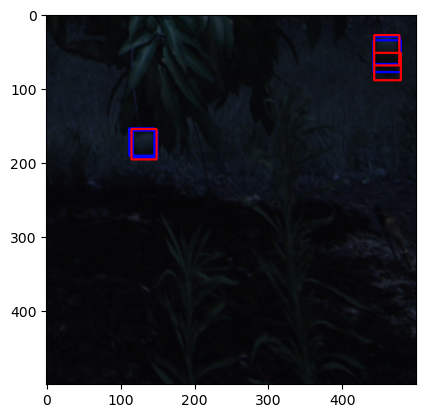

In [67]:
from transformers import AutoImageProcessor, AutoModelForObjectDetection
import torch
from PIL import Image
import requests
import numpy as np
import cv2

val_id = np.random.randint(0, len(val_dataset))

file_name = val_dataset.coco.loadImgs(
                                    val_dataset[val_id][1]["image_id"].item())[0]['file_name']


image = Image.open(os.path.join("datasets/acfr-fruit-dataset/mangoes/coco/val",
                           file_name
                   ))
image_processor = AutoImageProcessor.from_pretrained("facebook/detr-resnet-50")

cats = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}

val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=1)
pixel_values, pixel_mask, labels = list(iter(val_dataloader))[val_id].values()

outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)


# convert outputs (bounding boxes and class logits) to COCO API
target_sizes = torch.tensor([image.size[::-1]])
results = image_processor.post_process_object_detection(outputs, threshold=0.5, target_sizes=target_sizes)[
     0
]

image = np.array(image)
image = image[:,:,::-1].copy()
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
     box = [round(i, 2) for i in box.tolist()]
     print(
         f"Detected {id2label[label.item()]} with confidence "
         f"{round(score.item(), 3)} at location {box}"
     )
     cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), color=(0,0,255), thickness=2)

for idx, row in dataset["mangoes"]["global_df"].loc[dataset["mangoes"]["global_df"].picture_id == file_name[:-4]].iterrows():
    cv2.rectangle(image, (int(row.x), int(row.y)), (int(row.x) + int(row.dx), int(row.y) + int(row.dy)), color=(255,0,0), thickness=2)

plt.imshow(image)

## YOLOS

The "You Only Look at One Sequence" model or YOLOS for short, combines the original Vision Transformer (Dosovitskiy et al., 2021) with the object detection capabilities of DETR (Carion et al., 2020), in an effort to create a versatile, adaptable and spatially independent Transformer based object detection model (Fang et al., 2021). This is achieved, by taking the original Vision Transformer as it is and removing the classification token. Instead, 100 randomly initialized learnable Detection Tokens (``[DET]``) are appended to the input patch embeddings for object detection (Fang et al., 2021). These tokens serve the same purpose as the $N$ object queries in DETR and create one hundred different output embeddings. YOLOS Detector Heads then take the Detection Tokens as input and perform both the classification and bounding box regression through one Forward Neural Network with ReLu activations, containing two hidden layers. Because YOLOS internally only works with sequence and essentially create sequence to sequence embeddings, the model can in theory perform any dimensional object detection without the need of knowing the exact spatial structure and geometry (Fang et al., 2021). At the same time, because of its simplicity, the model can be easily adapted to other state-of-the-art transformer architectures from the NLP space such as BERT (Fang et al., 2021).

In order to Fine-Tune YOLOS on the acfr-fruit-dataset, again, a custom collate function has to be defined as the model does not expect a pixel mask as input because it doesn't support pixel-level segmentation. Other than that, the Training procedure for YOLOS remains the same as for DETR, as both models are trained in the same fashion using the same methods (Fang et al., 2021). The model is initialized using a pre-trained YOLOS checkpoint from Huggingface model hub, which has been pre-trained on ImageNet-1k and then Fine-Tuned on COCO 2017 object detection.

In [4]:
# custom collate function to pad images and convert them to the required format
def collate_fn(batch):
    pixel_values = [item[0] for item in batch]
    encoding = feature_extractor.pad(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]
    batch = {}
    batch['pixel_values'] = encoding['pixel_values']
    batch['labels'] = labels
    return batch

### Apples

In [22]:
from transformers import AutoFeatureExtractor
from torch.utils.data import DataLoader
import os

# define dataloaders and initialize feature extractor
feature_extractor = AutoFeatureExtractor.from_pretrained("hustvl/yolos-small", size=512, max_size=864)
train_dataset = CocoDetection(img_folder="datasets/acfr-fruit-dataset/apples/coco/train", feature_extractor=feature_extractor)
val_dataset = CocoDetection(img_folder="datasets/acfr-fruit-dataset/apples/coco/val", feature_extractor=feature_extractor, train=False)
train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=1, shuffle=True)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=1)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [5]:
import pytorch_lightning as pl
from transformers import AutoModelForObjectDetection
import torch

# define Yolos VIT as a Lightning Module, so it can be trained with pytorch lightning
class Yolos(pl.LightningModule):

    def __init__(self, lr, weight_decay, trained="hustvl/yolos-small"):
        super().__init__()
        self.model = AutoModelForObjectDetection.from_pretrained(trained,
                                                             num_labels=1,
                                                             ignore_mismatched_sizes=True) # init model
        self.lr = lr
        self.weight_decay = weight_decay

    def forward(self, pixel_values, output_attentions=False):
        return self.model(pixel_values=pixel_values, output_attentions=output_attentions)

    def common_step(self, batch): # step that is executed during training and evaluation
        pixel_values = batch["pixel_values"] # extract pixel values from batch
        labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]] # send labels to GPU and extract them from batch

        outputs = self.model(pixel_values=pixel_values, labels=labels) # run model and calculate losses
        return outputs.loss, outputs.loss_dict

    def training_step(self, batch, batch_idx): # train step with custom logging to Tensorboard
        loss, loss_dict = self.common_step(batch) # get losses and perform common step
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
            self.log("train_" + k, v.item())
        return loss

    def validation_step(self, batch, batch_idx): # validation step with custom logging to Tensorboard
        loss, loss_dict = self.common_step(batch)
        self.log("validation_loss", loss)
        for k,v in loss_dict.items():
          self.log("validation_" + k, v.item())
        return loss

    def configure_optimizers(self): # define Optimizer, AdamW is recommended for Yolos
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        return optimizer

    def train_dataloader(self):
        return train_dataloader

    def val_dataloader(self):
        return val_dataloader

In [23]:
# Check Shapes
batch = next(iter(train_dataloader))
print(batch.keys())
pixel, target = train_dataset[2]
print("pixel shape", pixel.shape)
print(target)

dict_keys(['pixel_values', 'labels'])
pixel shape torch.Size([3, 512, 780])
{'size': tensor([512, 780]), 'image_id': tensor([2]), 'class_labels': tensor([0, 0]), 'boxes': tensor([[0.2646, 0.1559, 0.1201, 0.1832],
        [0.4026, 0.1782, 0.1494, 0.2277]]), 'area': tensor([ 8978.5391, 13748.3057]), 'iscrowd': tensor([0, 0]), 'orig_size': tensor([202, 308])}


In [54]:
# initialize Model
model = Yolos(lr=2.5e-5, weight_decay=1e-4)
outputs = model(pixel_values=batch['pixel_values'])
outputs.logits.shape

Some weights of YolosForObjectDetection were not initialized from the model checkpoint at hustvl/yolos-small and are newly initialized because the shapes did not match:
- class_labels_classifier.layers.2.weight: found shape torch.Size([92, 384]) in the checkpoint and torch.Size([2, 384]) in the model instantiated
- class_labels_classifier.layers.2.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


torch.Size([1, 100, 2])

In [27]:
from pytorch_lightning import Trainer
# Train Model using pytorch lightning
torch.device("cuda")
trainer = Trainer(max_steps=2000, gradient_clip_val=0.1, accumulate_grad_batches=4, log_every_n_steps=10) # recommended settings for Yolos Training, custom logging step
trainer.fit(model=model) # start training

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                    | Params
--------------------------------------------------
0 | model | YolosForObjectDetection | 30.7 M
--------------------------------------------------
30.7 M    Trainable params
0         Non-trainable params
30.7 M    Total params
122.600   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_steps=2000` reached.


In [28]:
torch.save(model.state_dict(), "models/yolos_apples_v9.pt") # save model for reuse

In [55]:
model.load_state_dict(torch.load("models/yolos_apples_v9.pt")) # load saved model

<All keys matched successfully>

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


YolosObjectDetectionOutput(loss=None, loss_dict=None, logits=tensor([[[-4.5788,  2.0617],
         [-3.8508,  1.4761],
         [-1.2335, -1.9343],
         [-3.4292,  1.1534],
         [-3.4169,  1.0100],
         [-4.0340,  1.0225],
         [-2.1802, -0.9563],
         [-3.6305,  0.9137],
         [ 1.3971, -4.6544],
         [-4.4231,  3.0229],
         [-3.8521,  1.3301],
         [-3.9636,  1.7187],
         [-3.7593,  1.8635],
         [-3.0155,  0.8553],
         [-4.7436,  1.7102],
         [-4.2922,  1.3717],
         [-4.0870,  1.2082],
         [-4.6371,  1.6775],
         [-3.4885,  1.2046],
         [-4.4516,  2.3954],
         [-3.4768,  1.1695],
         [-5.1585,  1.8812],
         [-3.3357,  1.3112],
         [-5.4039,  2.9642],
         [-1.3846, -1.9272],
         [-4.4956,  2.0685],
         [-4.1236,  2.1797],
         [-4.6194,  2.0136],
         [-4.7092,  1.9141],
         [-3.3894,  1.2455],
         [-3.3569,  1.1214],
         [-3.4329,  1.6017],
         [-

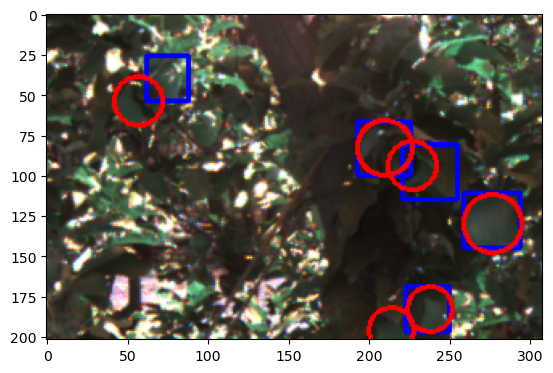

In [88]:
from transformers import AutoImageProcessor, AutoModelForObjectDetection
import torch
from PIL import Image
import requests
import numpy as np
import cv2

# Display random sample with predictions and grount truth to check if the model learned and works

val_id = np.random.randint(0, len(val_dataset))

file_name = val_dataset.coco.loadImgs(
                                    val_dataset[val_id][1]["image_id"].item())[0]['file_name']


image = Image.open(os.path.join("datasets/acfr-fruit-dataset/apples/coco/val",
                           file_name
                   ))
image_processor = AutoImageProcessor.from_pretrained("hustvl/yolos-tiny")

cats = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}


pixel_values = val_dataset[val_id][0].unsqueeze(0)

outputs = model(pixel_values=pixel_values)


# convert outputs (bounding boxes and class logits) to COCO API
target_sizes = torch.tensor([image.size[::-1]])
results = image_processor.post_process_object_detection(outputs, threshold=0.5, target_sizes=target_sizes)[
     0
]

image = np.array(image)
image = image[:,:,::-1].copy()
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]): # draw predictions
     box = [round(i, 2) for i in box.tolist()]
     print(
         f"Detected {id2label[label.item()]} with confidence "
         f"{round(score.item(), 3)} at location {box}"
     )
     cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), color=(0,0,255), thickness=2)

for idx, row in dataset["apples"]["global_df"].loc[dataset["apples"]["global_df"].picture_id == file_name[:-4]].iterrows(): # draw annotations
    cv2.circle(image, (int(row["c-x"]), int(row["c-y"])), int(row.radius), color=(255,0,0), thickness=2)

plt.imshow(image)

### Almonds

In [27]:
from transformers import AutoFeatureExtractor
from torch.utils.data import DataLoader
import os
feature_extractor = AutoFeatureExtractor.from_pretrained("hustvl/yolos-small", size=512, max_size=864)
train_dataset = CocoDetection(img_folder="datasets/acfr-fruit-dataset/almonds/coco/train", feature_extractor=feature_extractor)
val_dataset = CocoDetection(img_folder="datasets/acfr-fruit-dataset/almonds/coco/val", feature_extractor=feature_extractor, train=False)
train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=1, shuffle=True)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=1)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


/opt/conda/envs/pytorch/lib/python3.9/site-packages/transformers/models/yolos/feature_extraction_yolos.py:28: FutureWarning: The class YolosFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use YolosImageProcessor instead.
  warnings.warn(
/opt/conda/envs/pytorch/lib/python3.9/site-packages/transformers/models/yolos/image_processing_yolos.py:710: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(


In [28]:
from pytorch_lightning import Trainer

# max_steps = 2000
max_steps = 734 # Overfitting Retraining

torch.device("cuda")
model = Yolos(lr=2.5e-5, weight_decay=1e-4)
trainer = Trainer(max_steps=max_steps, gradient_clip_val=0.1, accumulate_grad_batches=4, log_every_n_steps=10)
trainer.fit(model=model)

Some weights of YolosForObjectDetection were not initialized from the model checkpoint at hustvl/yolos-small and are newly initialized because the shapes did not match:
- class_labels_classifier.layers.2.weight: found shape torch.Size([92, 384]) in the checkpoint and torch.Size([2, 384]) in the model instantiated
- class_labels_classifier.layers.2.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                    | Params
--------------------------------------------------
0 | model | YolosForObjectDetection | 30.7 M
--------------------------------------------------
30.7 M    Trainable params
0         Non-trainable pa

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_steps=734` reached.


In [29]:
torch.save(model.state_dict(), "models/yolos_almonds_v2_734.pt")

/opt/conda/envs/pytorch/lib/python3.9/site-packages/transformers/models/yolos/image_processing_yolos.py:824: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
/opt/conda/envs/pytorch/lib/python3.9/site-packages/transformers/models/yolos/image_processing_yolos.py:710: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(


Detected almond with confidence 0.982 at location [83.47, 212.32, 112.66, 236.3]
Detected almond with confidence 0.786 at location [28.91, 185.81, 51.52, 203.79]
Detected almond with confidence 0.979 at location [43.6, 6.97, 69.04, 28.34]
Detected almond with confidence 0.557 at location [246.8, 44.7, 265.72, 65.8]
Detected almond with confidence 0.621 at location [269.43, 164.55, 288.21, 181.25]
Detected almond with confidence 0.996 at location [105.74, 195.32, 130.62, 219.98]
Detected almond with confidence 0.941 at location [105.35, 214.36, 127.04, 234.72]
Detected almond with confidence 0.843 at location [0.5, 43.24, 18.65, 64.42]
Detected almond with confidence 0.78 at location [63.55, 30.81, 89.31, 58.89]
Detected almond with confidence 0.989 at location [127.85, 169.94, 153.67, 192.83]
Detected almond with confidence 0.854 at location [145.71, 31.3, 169.58, 58.03]
Detected almond with confidence 0.954 at location [109.33, 0.52, 133.88, 18.03]
Detected almond with confidence 0.55

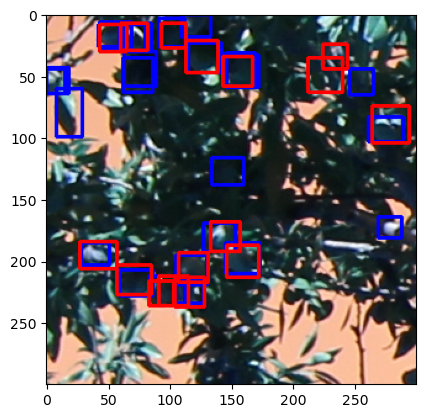

In [33]:
from transformers import AutoImageProcessor, AutoModelForObjectDetection
import torch
from PIL import Image
import requests
import numpy as np
import cv2

val_id = np.random.randint(0, len(val_dataset))

file_name = val_dataset.coco.loadImgs(
                                    val_dataset[val_id][1]["image_id"].item())[0]['file_name']


image = Image.open(os.path.join("datasets/acfr-fruit-dataset/almonds/coco/val",
                           file_name
                   ))
image_processor = AutoImageProcessor.from_pretrained("hustvl/yolos-tiny")

cats = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}


pixel_values = val_dataset[val_id][0].unsqueeze(0)

outputs = model(pixel_values=pixel_values)


# convert outputs (bounding boxes and class logits) to COCO API
target_sizes = torch.tensor([image.size[::-1]])
results = image_processor.post_process_object_detection(outputs, threshold=0.5, target_sizes=target_sizes)[
     0
]

image = np.array(image)
image = image[:,:,::-1].copy()
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
     box = [round(i, 2) for i in box.tolist()]
     print(
         f"Detected {id2label[label.item()]} with confidence "
         f"{round(score.item(), 3)} at location {box}"
     )
     cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), color=(0,0,255), thickness=2)

for idx, row in dataset["almonds"]["global_df"].loc[dataset["almonds"]["global_df"].picture_id == file_name[:-4]].iterrows():
    cv2.rectangle(image, (int(row.x), int(row.y)), (int(row.x) + int(row.dx), int(row.y) + int(row.dy)), color=(255,0,0), thickness=2)

plt.imshow(image)

### Mangoes

In [35]:
from transformers import AutoFeatureExtractor
from torch.utils.data import DataLoader
import os
feature_extractor = AutoFeatureExtractor.from_pretrained("hustvl/yolos-small", size=512, max_size=864)
train_dataset = CocoDetection(img_folder="datasets/acfr-fruit-dataset/mangoes/coco/train", feature_extractor=feature_extractor)
val_dataset = CocoDetection(img_folder="datasets/acfr-fruit-dataset/mangoes/coco/val", feature_extractor=feature_extractor, train=False)
train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=1, shuffle=True)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=1)

from pytorch_lightning import Trainer

# max_steps = 2000
max_steps = 1463 # Overfitting Retraining

torch.device("cuda")
model = Yolos(lr=2.5e-5, weight_decay=1e-4)
trainer = Trainer(max_steps=max_steps, gradient_clip_val=0.1, accumulate_grad_batches=4, log_every_n_steps=10)
trainer.fit(model=model)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


Some weights of YolosForObjectDetection were not initialized from the model checkpoint at hustvl/yolos-small and are newly initialized because the shapes did not match:
- class_labels_classifier.layers.2.weight: found shape torch.Size([92, 384]) in the checkpoint and torch.Size([2, 384]) in the model instantiated
- class_labels_classifier.layers.2.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                    | Params
--------------------------------------------------
0 | model | YolosForObjectDetection | 30.7 M
--------------------------------------------------
30.7 M    Trainable params
0         Non-trainable pa

Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/envs/pytorch/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/conda/envs/pytorch/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_steps=1463` reached.


In [36]:
torch.save(model.state_dict(), "models/yolos_mangoes_v2_1463.pt")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


Detected mango with confidence 0.873 at location [353.86, 438.43, 385.9, 478.63]
Detected mango with confidence 0.551 at location [351.93, 440.94, 384.56, 479.43]
Detected mango with confidence 0.984 at location [371.39, 0.38, 401.25, 29.0]
Detected mango with confidence 0.993 at location [292.0, 60.03, 320.45, 90.08]
Detected mango with confidence 0.986 at location [403.18, 440.4, 428.12, 472.8]
Detected mango with confidence 0.974 at location [260.64, 104.69, 285.09, 131.67]
Detected mango with confidence 0.991 at location [68.58, 48.64, 97.82, 78.12]
Detected mango with confidence 0.989 at location [304.46, 303.33, 336.2, 343.44]
Detected mango with confidence 0.885 at location [321.71, 470.32, 360.23, 499.61]
Detected mango with confidence 0.967 at location [300.66, 446.52, 336.95, 484.64]
Detected mango with confidence 0.786 at location [457.8, 481.05, 484.77, 499.72]


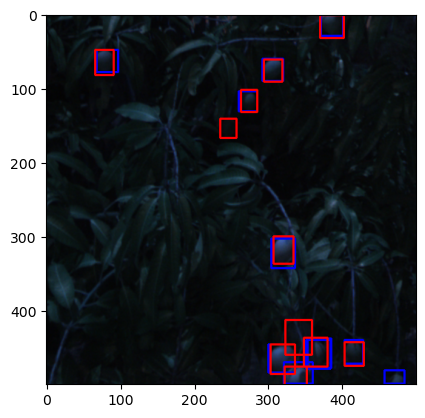

In [38]:
from transformers import AutoImageProcessor, AutoModelForObjectDetection
import torch
from PIL import Image
import requests
import numpy as np
import cv2

val_id = np.random.randint(0, len(val_dataset))

file_name = val_dataset.coco.loadImgs(
                                    val_dataset[val_id][1]["image_id"].item())[0]['file_name']


image = Image.open(os.path.join("datasets/acfr-fruit-dataset/mangoes/coco/val",
                           file_name
                   ))
image_processor = AutoImageProcessor.from_pretrained("hustvl/yolos-tiny")

cats = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}


pixel_values = val_dataset[val_id][0].unsqueeze(0)

outputs = model(pixel_values=pixel_values)


# convert outputs (bounding boxes and class logits) to COCO API
target_sizes = torch.tensor([image.size[::-1]])
results = image_processor.post_process_object_detection(outputs, threshold=0.5, target_sizes=target_sizes)[
     0
]

image = np.array(image)
image = image[:,:,::-1].copy()
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
     box = [round(i, 2) for i in box.tolist()]
     print(
         f"Detected {id2label[label.item()]} with confidence "
         f"{round(score.item(), 3)} at location {box}"
     )
     cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), color=(0,0,255), thickness=2)

for idx, row in dataset["mangoes"]["global_df"].loc[dataset["mangoes"]["global_df"].picture_id == file_name[:-4]].iterrows():
    cv2.rectangle(image, (int(row.x), int(row.y)), (int(row.x) + int(row.dx), int(row.y) + int(row.dy)), color=(255,0,0), thickness=2)

plt.imshow(image)

## Evaluation
In the following, all Fine-Tuned checkpoints for both models are evaluated using the COCO Evaluator on their respective validation datasets.
The result of each validation run is also saved in the ``evaluation_results`` directory, for reproducibility. The models are stored in the ``models`` directory. The evaluation procedure is the same for both YOLOS and DETR respectively.

### Yolos
In the following all Fine-Tuned YOLOS checkpoints are evaluated using the COCO Evaluator.

#### Apples

In order to evaluate a checkpoint, first the dataset, feature extractor and model have to be initialized. Then the Coco evaluator is created by passing it the validation dataset for target data extraction. The model is then set to evaluation mode, disabling gradient calculation and freezing weights. After that, each batch from the validation data loader is passed through the model, generating the corresponding predictions, which are then converted to bounding box coordinates and labels by the featue extractors ``post_process`` method. The evaluator is then updated with the retrieved predictions. Last but not least, all results are accumulated and a summary is displayed. This procedure is repeated for every model Fine-Tuned checkpoint of YOLOS and DETR on their respective data subsets (Apples, mangoes, almonds).

In [35]:
from coco_eval import CocoEvaluator, get_coco_api_from_dataset
from tqdm.notebook import tqdm

from transformers import AutoFeatureExtractor
from torch.utils.data import DataLoader
import os

# Initialize Datasets and Feature Extractor
feature_extractor = AutoFeatureExtractor.from_pretrained("hustvl/yolos-small", size=512, max_size=864)
train_dataset = CocoDetection(img_folder="datasets/acfr-fruit-dataset/apples/coco/train", feature_extractor=feature_extractor)
val_dataset = CocoDetection(img_folder="datasets/acfr-fruit-dataset/apples/coco/val", feature_extractor=feature_extractor, train=False)
train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=1, shuffle=True)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=1)

# Initialize Model
model = Yolos(lr=2.5e-5, weight_decay=1e-4)
model.load_state_dict(torch.load("models/yolos_apples_v9.pt")) # load Model from Fine-Tuned Checkpoint


# initialize COCO evaluator with ground truths
base_ds = get_coco_api_from_dataset(val_dataset)
iou_types = ['bbox']
coco_evaluator = CocoEvaluator(base_ds, iou_types)

# set torch device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
model.eval()

print("Running evaluation...")

for idx, batch in enumerate(tqdm(val_dataloader)):
    # get the inputs
    pixel_values = batch["pixel_values"].to(device)
    labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]] # these are in DETR format, resized + normalized

    # forward pass
    outputs = model.model(pixel_values=pixel_values)

    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = feature_extractor.post_process(outputs, orig_target_sizes) # convert outputs of model to COCO api
    res = {target['image_id'].item(): output for target, output in zip(labels, results)}
    coco_evaluator.update(res)

coco_evaluator.synchronize_between_processes()
coco_evaluator.accumulate()
coco_evaluator.summarize()

Running evaluation...


  0%|          | 0/112 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.07s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.473
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.862
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.452
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.294
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.528
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.130
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.541
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.621
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.543
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.648
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= l

#### Almonds

In [34]:
from coco_eval import CocoEvaluator, get_coco_api_from_dataset
from tqdm.notebook import tqdm


from transformers import AutoFeatureExtractor
from torch.utils.data import DataLoader
import os
feature_extractor = AutoFeatureExtractor.from_pretrained("hustvl/yolos-small", size=512, max_size=864)
train_dataset = CocoDetection(img_folder="datasets/acfr-fruit-dataset/almonds/coco/train", feature_extractor=feature_extractor)
val_dataset = CocoDetection(img_folder="datasets/acfr-fruit-dataset/almonds/coco/val", feature_extractor=feature_extractor, train=False)
train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=1, shuffle=True)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=1)

model = Yolos(lr=2.5e-5, weight_decay=1e-4)
model.load_state_dict(torch.load("models/yolos_almonds_v2_734.pt"))


base_ds = get_coco_api_from_dataset(val_dataset)
iou_types = ['bbox']
coco_evaluator = CocoEvaluator(base_ds, iou_types) # initialize evaluator with ground truths

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
model.eval()

print("Running evaluation...")

for idx, batch in enumerate(tqdm(val_dataloader)):
    # get the inputs
    pixel_values = batch["pixel_values"].to(device)
    labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]] # these are in DETR format, resized + normalized

    # forward pass
    outputs = model.model(pixel_values=pixel_values)

    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = feature_extractor.post_process(outputs, orig_target_sizes) # convert outputs of model to COCO api
    res = {target['image_id'].item(): output for target, output in zip(labels, results)}
    coco_evaluator.update(res)

coco_evaluator.synchronize_between_processes()
coco_evaluator.accumulate()
coco_evaluator.summarize()

/opt/conda/envs/pytorch/lib/python3.9/site-packages/transformers/models/yolos/feature_extraction_yolos.py:28: FutureWarning: The class YolosFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use YolosImageProcessor instead.
  warnings.warn(
/opt/conda/envs/pytorch/lib/python3.9/site-packages/transformers/models/yolos/image_processing_yolos.py:710: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


Some weights of YolosForObjectDetection were not initialized from the model checkpoint at hustvl/yolos-small and are newly initialized because the shapes did not match:
- class_labels_classifier.layers.2.weight: found shape torch.Size([92, 384]) in the checkpoint and torch.Size([2, 384]) in the model instantiated
- class_labels_classifier.layers.2.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running evaluation...


  0%|          | 0/100 [00:00<?, ?it/s]

/opt/conda/envs/pytorch/lib/python3.9/site-packages/transformers/models/yolos/image_processing_yolos.py:824: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(
/opt/conda/envs/pytorch/lib/python3.9/site-packages/transformers/models/yolos/image_processing_yolos.py:1167: FutureWarning: `post_process` is deprecated and will be removed in v5 of Transformers, please use `post_process_object_detection`
  warnings.warn(


Accumulating evaluation results...
DONE (t=0.07s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.309
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.714
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.200
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.292
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.454
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.057
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.337
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.515
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.506
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.594
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= l

#### Mangoes

In [39]:
from coco_eval import CocoEvaluator, get_coco_api_from_dataset
from tqdm.notebook import tqdm

from transformers import AutoFeatureExtractor
from torch.utils.data import DataLoader
import os
feature_extractor = AutoFeatureExtractor.from_pretrained("hustvl/yolos-small", size=512, max_size=864)
train_dataset = CocoDetection(img_folder="datasets/acfr-fruit-dataset/mangoes/coco/train", feature_extractor=feature_extractor)
val_dataset = CocoDetection(img_folder="datasets/acfr-fruit-dataset/mangoes/coco/val", feature_extractor=feature_extractor, train=False)
train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=1, shuffle=True)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=1)

model = Yolos(lr=2.5e-5, weight_decay=1e-4)
model.load_state_dict(torch.load("models/yolos_mangoes_v2_1463.pt"))

base_ds = get_coco_api_from_dataset(val_dataset)
iou_types = ['bbox']
coco_evaluator = CocoEvaluator(base_ds, iou_types) # initialize evaluator with ground truths

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
model.eval()

print("Running evaluation...")

for idx, batch in enumerate(tqdm(val_dataloader)):
    # get the inputs
    pixel_values = batch["pixel_values"].to(device)
    labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]] # these are in DETR format, resized + normalized

    # forward pass
    outputs = model.model(pixel_values=pixel_values)

    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = feature_extractor.post_process(outputs, orig_target_sizes) # convert outputs of model to COCO api
    res = {target['image_id'].item(): output for target, output in zip(labels, results)}
    coco_evaluator.update(res)

coco_evaluator.synchronize_between_processes()
coco_evaluator.accumulate()
coco_evaluator.summarize()

/opt/conda/envs/pytorch/lib/python3.9/site-packages/transformers/models/yolos/feature_extraction_yolos.py:28: FutureWarning: The class YolosFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use YolosImageProcessor instead.
  warnings.warn(
/opt/conda/envs/pytorch/lib/python3.9/site-packages/transformers/models/yolos/image_processing_yolos.py:710: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


Some weights of YolosForObjectDetection were not initialized from the model checkpoint at hustvl/yolos-small and are newly initialized because the shapes did not match:
- class_labels_classifier.layers.2.weight: found shape torch.Size([92, 384]) in the checkpoint and torch.Size([2, 384]) in the model instantiated
- class_labels_classifier.layers.2.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running evaluation...


  0%|          | 0/250 [00:00<?, ?it/s]

/opt/conda/envs/pytorch/lib/python3.9/site-packages/transformers/models/yolos/image_processing_yolos.py:824: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(
/opt/conda/envs/pytorch/lib/python3.9/site-packages/transformers/models/yolos/image_processing_yolos.py:1167: FutureWarning: `post_process` is deprecated and will be removed in v5 of Transformers, please use `post_process_object_detection`
  warnings.warn(


Accumulating evaluation results...
DONE (t=0.16s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.402
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.829
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.326
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.280
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.461
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.113
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.472
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.549
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.482
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.583
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= l

### Detr

#### Apples

In [59]:
from coco_eval import CocoEvaluator, get_coco_api_from_dataset
from tqdm.notebook import tqdm

from transformers import AutoFeatureExtractor
from torch.utils.data import DataLoader
import os
feature_extractor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
train_dataset = CocoDetection(img_folder="datasets/acfr-fruit-dataset/apples/coco/train", feature_extractor=feature_extractor)
val_dataset = CocoDetection(img_folder="datasets/acfr-fruit-dataset/apples/coco/val", feature_extractor=feature_extractor, train=False)
train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=1, shuffle=True)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=1)

model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)
model.load_state_dict(torch.load("models/detr_apples_v1.pt"))


base_ds = get_coco_api_from_dataset(val_dataset)
iou_types = ['bbox']
coco_evaluator = CocoEvaluator(base_ds, iou_types) # initialize evaluator with ground truths

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
model.eval()

print("Running evaluation...")

for idx, batch in enumerate(tqdm(val_dataloader)):
    # get the inputs
    pixel_values = batch["pixel_values"].to(device)
    labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]] # these are in DETR format, resized + normalized

    # forward pass
    outputs = model.model(pixel_values=pixel_values)

    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = feature_extractor.post_process(outputs, orig_target_sizes) # convert outputs of model to COCO api
    res = {target['image_id'].item(): output for target, output in zip(labels, results)}
    coco_evaluator.update(res)

coco_evaluator.synchronize_between_processes()
coco_evaluator.accumulate()
coco_evaluator.summarize()

/opt/conda/envs/pytorch/lib/python3.9/site-packages/transformers/models/detr/image_processing_detr.py:780: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running evaluation...


  0%|          | 0/112 [00:00<?, ?it/s]

/opt/conda/envs/pytorch/lib/python3.9/site-packages/transformers/models/detr/image_processing_detr.py:886: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(
/opt/conda/envs/pytorch/lib/python3.9/site-packages/transformers/models/detr/image_processing_detr.py:1266: FutureWarning: `post_process` is deprecated and will be removed in v5 of Transformers, please use `post_process_object_detection`
  warnings.warn(


Accumulating evaluation results...
DONE (t=0.08s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.406
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.760
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.386
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.217
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.471
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.129
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.480
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.544
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.424
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.586
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= l

#### Almonds

In [69]:
from coco_eval import CocoEvaluator, get_coco_api_from_dataset
from tqdm.notebook import tqdm

from transformers import AutoFeatureExtractor
from torch.utils.data import DataLoader
import os
feature_extractor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
train_dataset = CocoDetection(img_folder="datasets/acfr-fruit-dataset/almonds/coco/train", feature_extractor=feature_extractor)
val_dataset = CocoDetection(img_folder="datasets/acfr-fruit-dataset/almonds/coco/val", feature_extractor=feature_extractor, train=False)
train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=1, shuffle=True)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=1)

model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)
model.load_state_dict(torch.load("models/detr_almonds_v1.pt"))


base_ds = get_coco_api_from_dataset(val_dataset)
iou_types = ['bbox']
coco_evaluator = CocoEvaluator(base_ds, iou_types) # initialize evaluator with ground truths

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
model.eval()

print("Running evaluation...")

for idx, batch in enumerate(tqdm(val_dataloader)):
    # get the inputs
    pixel_values = batch["pixel_values"].to(device)
    labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]] # these are in DETR format, resized + normalized

    # forward pass
    outputs = model.model(pixel_values=pixel_values)

    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = feature_extractor.post_process(outputs, orig_target_sizes) # convert outputs of model to COCO api
    res = {target['image_id'].item(): output for target, output in zip(labels, results)}
    coco_evaluator.update(res)

coco_evaluator.synchronize_between_processes()
coco_evaluator.accumulate()
coco_evaluator.summarize()

/opt/conda/envs/pytorch/lib/python3.9/site-packages/transformers/models/detr/image_processing_detr.py:780: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running evaluation...


  0%|          | 0/100 [00:00<?, ?it/s]

/opt/conda/envs/pytorch/lib/python3.9/site-packages/transformers/models/detr/image_processing_detr.py:886: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(
/opt/conda/envs/pytorch/lib/python3.9/site-packages/transformers/models/detr/image_processing_detr.py:1266: FutureWarning: `post_process` is deprecated and will be removed in v5 of Transformers, please use `post_process_object_detection`
  warnings.warn(


Accumulating evaluation results...
DONE (t=0.07s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.274
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.640
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.173
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.260
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.407
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.052
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.314
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.446
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.438
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.522
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= l

#### Mangoes

In [70]:
from coco_eval import CocoEvaluator, get_coco_api_from_dataset
from tqdm.notebook import tqdm

from transformers import AutoFeatureExtractor
from torch.utils.data import DataLoader
import os
feature_extractor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
train_dataset = CocoDetection(img_folder="datasets/acfr-fruit-dataset/mangoes/coco/train", feature_extractor=feature_extractor)
val_dataset = CocoDetection(img_folder="datasets/acfr-fruit-dataset/mangoes/coco/val", feature_extractor=feature_extractor, train=False)
train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=1, shuffle=True)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=1)

model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)
model.load_state_dict(torch.load("models/detr_mangoes_v1.pt"))


base_ds = get_coco_api_from_dataset(val_dataset)
iou_types = ['bbox']
coco_evaluator = CocoEvaluator(base_ds, iou_types) # initialize evaluator with ground truths

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
model.eval()

print("Running evaluation...")

for idx, batch in enumerate(tqdm(val_dataloader)):
    # get the inputs
    pixel_values = batch["pixel_values"].to(device)
    labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]] # these are in DETR format, resized + normalized

    # forward pass
    outputs = model.model(pixel_values=pixel_values)

    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = feature_extractor.post_process(outputs, orig_target_sizes) # convert outputs of model to COCO api
    res = {target['image_id'].item(): output for target, output in zip(labels, results)}
    coco_evaluator.update(res)

coco_evaluator.synchronize_between_processes()
coco_evaluator.accumulate()
coco_evaluator.summarize()

/opt/conda/envs/pytorch/lib/python3.9/site-packages/transformers/models/detr/image_processing_detr.py:780: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running evaluation...


  0%|          | 0/250 [00:00<?, ?it/s]

/opt/conda/envs/pytorch/lib/python3.9/site-packages/transformers/models/detr/image_processing_detr.py:886: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(
/opt/conda/envs/pytorch/lib/python3.9/site-packages/transformers/models/detr/image_processing_detr.py:1266: FutureWarning: `post_process` is deprecated and will be removed in v5 of Transformers, please use `post_process_object_detection`
  warnings.warn(


Accumulating evaluation results...
DONE (t=0.16s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.353
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.733
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.289
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.224
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.410
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.105
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.432
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.509
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.450
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.539
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= l

<AxesSubplot: xlabel='model'>

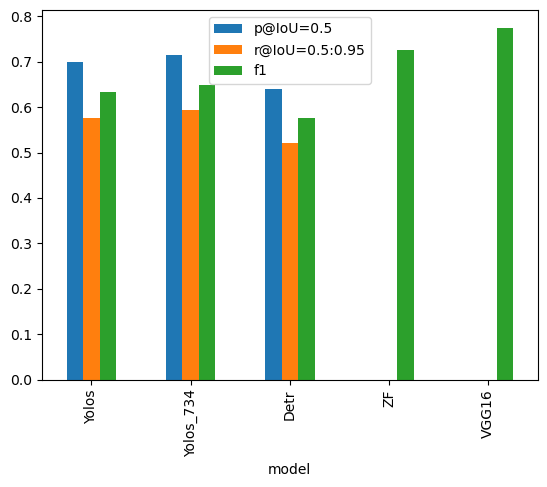

In [19]:
# almonds
p = [0.7, 0.714, 0.640]
r = [0.577, 0.594, 0.522]
models = ["Yolos", "Yolos_734", "Detr"]
df = pd.DataFrame(
    {
        "p@IoU=0.5": p,
        "r@IoU=0.5:0.95": r,
        "model": models
    })
df["f1"] = 2*((df["p@IoU=0.5"] * df["r@IoU=0.5:0.95"]) / (df["p@IoU=0.5"] + df["r@IoU=0.5:0.95"]))
baselines = pd.DataFrame({
    "p@IoU=0.5": [0,0],
    "r@IoU=0.5:0.95": [0,0],
    "f1": [0.726, 0.775],
    "model": ["ZF", "VGG16"]
})
df = pd.concat([df, baselines])
df.set_index(df.model, inplace=True)
df.plot.bar()

<AxesSubplot: xlabel='model'>

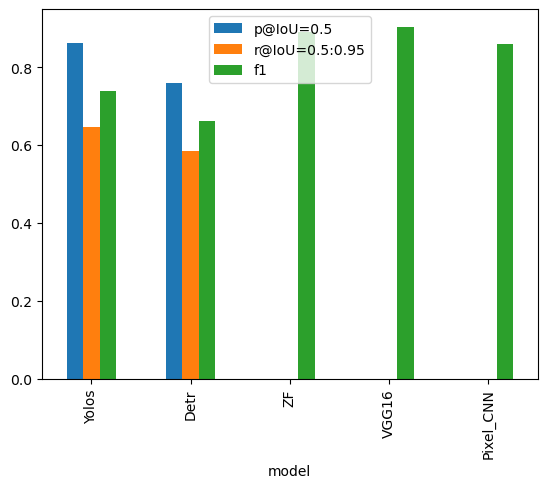

In [20]:
# apples
p = [0.862, 0.760]
r = [0.648, 0.586]
models = ["Yolos", "Detr"]
df = pd.DataFrame(
    {
        "p@IoU=0.5": p,
        "r@IoU=0.5:0.95": r,
        "model": models
    })
df["f1"] = 2*((df["p@IoU=0.5"] * df["r@IoU=0.5:0.95"]) / (df["p@IoU=0.5"] + df["r@IoU=0.5:0.95"]))
baselines = pd.DataFrame({
    "p@IoU=0.5": [0,0, 0],
    "r@IoU=0.5:0.95": [0,0, 0],
    "f1": [0.892, 0.904, 0.861],
    "model": ["ZF", "VGG16", "Pixel_CNN"]
})
df = pd.concat([df, baselines])
df.set_index(df.model, inplace=True)
df.plot.bar()

<AxesSubplot: xlabel='model'>

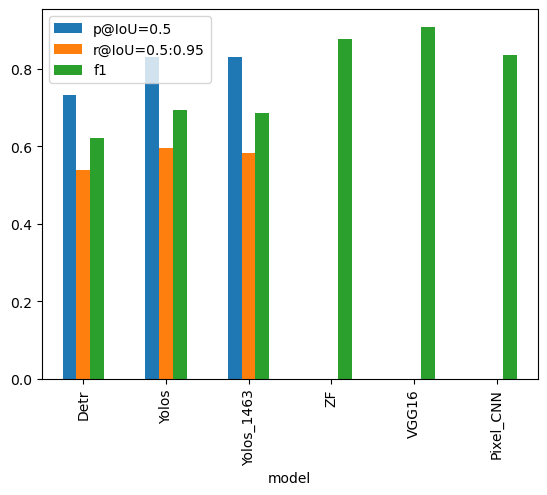

In [21]:
# Mangoes
p = [0.733, 0.831, 0.829]
r = [ 0.539, 0.596, 0.583]
models = ["Detr", "Yolos", "Yolos_1463"]
df = pd.DataFrame(
    {
        "p@IoU=0.5": p,
        "r@IoU=0.5:0.95": r,
        "model": models
    })
df["f1"] = 2*((df["p@IoU=0.5"] * df["r@IoU=0.5:0.95"]) / (df["p@IoU=0.5"] + df["r@IoU=0.5:0.95"]))
baselines = pd.DataFrame({
    "p@IoU=0.5": [0,0, 0],
    "r@IoU=0.5:0.95": [0,0, 0],
    "f1": [0.876, 0.908, 0.836],
    "model": ["ZF", "VGG16", "Pixel_CNN"]
})
df = pd.concat([df, baselines])
df.set_index(df.model, inplace=True)
df.plot.bar()

In [1]:
import pandas as pd
# Inference Times
df = pd.DataFrame({
    "ms/frame": [116, 148, 19.5, 17, 37, 55, 130, 40, 2500],
    "Parameters (M)": [41.5, 30.7, 5.2, 7.9, 7.9, 60,136, 60, None],
    "model": ["Detr", "Yolos", "YoloV5s-Dragon-Fruit", "Yolov5-CS-Server", "Yolov5-CS-JetsonNX", "Yolo BP", "VGG16", "ZF", "Pixel-Wise CNN"]
})
df["fps"] = (1000 / df["ms/frame"]).astype(int)
df.set_index("model", inplace=True)
df

,ms/frame,Parameters (M),fps
model,,,
Detr,116.0,41.5,8
Yolos,148.0,30.7,6
YoloV5s-Dragon-Fruit,19.5,5.2,51
Yolov5-CS-Server,17.0,7.9,58
Yolov5-CS-JetsonNX,37.0,7.9,27
Yolo BP,55.0,60.0,18
VGG16,130.0,136.0,7
ZF,40.0,60.0,25
Pixel-Wise CNN,2500.0,NaN,0


## Conclusion